In [15]:
import sys
from tqdm.notebook import tqdm
import argparse
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import seaborn as sns
from iotbx.data_manager import DataManager
from cctbx.array_family import flex
import random

def sphere_points(ctr, rad, N):
    if ctr.ndim==1:
        ctr = ctr[None,:]
    h = -1.0 + (2.0 * np.arange(N) / float(N-1))[:, np.newaxis]
    phis = np.arccos(h)
    thetas = np.zeros_like(phis)
    thetas[1:-1, :] = (3.6 / np.sqrt(N * (1.0 - h[1:-1]**2))) % (2 * np.pi)
    thetas = np.cumsum(thetas, axis=0)

    x = np.sin(phis) * np.cos(thetas)
    y = np.sin(phis) * np.sin(thetas)
    z = np.cos(phis)

    # Stack x, y, z to form points and multiply by rad
    points = rad * np.stack([x, y, z], axis=-1)

    # Reshape points to (1, N, 3)
    points = points.reshape(1, N, 3)

    # Add center coordinates to all points
    # ctr shape: (M, 3), points shape: (1, N, 3)
    # Resultant shape: (M, N, 3)
    pts = ctr[:, np.newaxis, :] + points


    return pts


# def SpherePtsOld ( ctr, rad, N ) :
#     import numpy
#     thetas, phis = [], []
#     from math import acos, sin, cos, sqrt, pi
#     for k in range ( 1, N+1 ) :
#         h = -1.0 + ( 2.0*float(k-1)/float(N-1) )
#         phis.append ( acos(h) )
#         thetas.append ( 0 if k == 1 or k == N else
#                         (thetas[k-2] + 3.6/sqrt(N*(1.0-h**2.0))) % (2*pi) )

#     pts = [None] * N
#     for i, theta, phi in zip ( range(N), thetas, phis ):
#         v = numpy.array([sin(phi)*cos(theta), sin(phi)*sin(theta), cos(phi)])
#         pt = ctr + v * rad
#         pts[i] = pt

    return np.array(pts)[None,:]
    
def points_to_bild(points,outfile="debug.bild",radius=0.1,color="purple"):
    """
    Write a .bild file to vizualize radial points in Chimera.
    
    Args:
        points: np array of shape (n_points,3)
        outfile: File path to write out
        radius: radius to use when depicting the points
        color: color of points. One of the Chimera color keywords
    """
    colors = ["red","yellow","orange","lime","forest green","cyan","cornflower blue","purple","magenta","gray"]
    if color is None:
        color = random.choice(colors)
    bild_lines = []
    for p in np.vstack(points):
        s = ".color "+color+"\n.sphere "+" ".join(str(v) for v in p)+" %s"%str(radius)+"\n"
        bild_lines.append(s)
    with open(outfile,"w") as fh:
        fh.writelines(bild_lines)


    
def points_for_density(radii, density,min_value=1):
    return max(min_value,np.round(density * 4 * np.pi * radii**2).astype(int))
    


In [49]:
mmm.resolution()

2.2799225340884077

In [16]:

import numpy as np


def min_max_normalize(distribution):
    min_val = np.min(distribution)
    max_val = np.max(distribution)

    normalized_dist = (distribution - min_val) / (max_val - min_val)

    return normalized_dist



In [17]:



def fisher(r):
    z = 0.5 * np.log((1 + r) / (1 - r))
    return z

In [18]:
import numpy as np
from mp_generic import *

In [19]:
from tqdm.notebook import tqdm
# class Args:
#   # model = "debug_model.pdb"
#   # map = "debug_map.mrc"
#   model = "data/6cvm.pdb"
#   model = "data/6cvm.pdb"
#   n_radial_shells=21
#   n_probes_per_shell=32
#   selection = "all"#"chain C and resid 243"
#   quiet=False

# model = "../model_debug1.pdb"
## map = "../map_debug1_res_1.0.mrc"
model = "../clutter/data/6cvm_frag.pdb"
#model = "../clutter/data/6cvm_chainA_prot.pdb"
#model = "../clutter/data/6cvm.pdb"
map = "../clutter/data/emd_7770.map"
dm = DataManager()
dm.process_model_file(model)
dm.process_real_map_file(map)
mmm = dm.get_map_model_manager()
mm = mmm.map_manager()
model = mmm.model()
d_min = mmm.resolution()
volume = mm.map_data().as_numpy_array()
atoms_xyz = model.get_sites_cart().as_numpy_array()
voxel_size = mm.pixel_sizes()[0]
grid_shape = volume.shape
radius = 2.0
#n_atoms = model.get_number_of_atoms()
# args = {"n_shells":21,
#         "n_probes":,
#         "voxel_size":voxel_size,
#         "radius":2.0,
#         "rtol":0.05,
#         "min_probes":4,
#         "min_rad":1.2,
#         "voxel_size":voxel_size,

#          }
# n_shells = args["n_shells"]
# n_probes = args["n_probes"]
# radius = args["radius"]
# rtol = args["rtol"]
# voxel_size = args["voxel_size"]
# min_rad = args["min_rad"]
# min_probes = args["min_probes"]

In [20]:
# model_sel = model.select(model.selection("chain A and protein and resid 20:25"))
# dm.write_model_file(model_sel.model_as_pdb(),filename="../clutter/data/6cvm_frag.pdb",overwrite=True)

In [21]:
# density_flex = mm.density_at_sites_cart(model.get_sites_cart()).as_numpy_array()
# density_tri = trilinear_interpolation(volume,atoms_xyz,np.array([mm.pixel_sizes()]))
# assert np.all(np.isclose(density_flex,density_tri))

In [22]:
import multiprocessing
from multiprocessing import Pool
import numpy as np


import numpy as np
import math
from itertools import product
from multiprocessing import Process, Array, JoinableQueue, Value
import ctypes
import numpy as np
import numpy.ma as ma


def mean(array):
    return np.mean(array,axis=1)[:,None]

def rowwise_corrcoef(A, B, mask=None):
    assert A.shape == B.shape, f"A and B must have the same shape, got: {A.shape} and {B.shape}"
    
    if mask is not None:
        assert mask.shape == A.shape, "mask must have the same shape as A and B"
        A = ma.masked_array(A, mask=np.logical_not(mask))
        B = ma.masked_array(B, mask=np.logical_not(mask))

    # Calculate means
    A_mean = ma.mean(A, axis=1, keepdims=True)
    B_mean = ma.mean(B, axis=1, keepdims=True)
    
    # Subtract means
    A_centered = A - A_mean
    B_centered = B - B_mean
    
    # Calculate sum of products
    sumprod = ma.sum(A_centered * B_centered, axis=1)
    
    # Calculate square roots of the sum of squares
    sqrt_sos_A = ma.sqrt(ma.sum(A_centered**2, axis=1))
    sqrt_sos_B = ma.sqrt(ma.sum(B_centered**2, axis=1))
    
    # Return correlation coefficients
    cc =  sumprod / (sqrt_sos_A * sqrt_sos_B)
    return cc.data

def trilinear_interpolation(voxel_grid, coords, voxel_size=None, offset=None):
    assert voxel_size is not None, "Provide voxel size as an array or single value"
    
    # Apply offset if provided
    if offset is not None:
        coords = coords - offset

    # Transform coordinates to voxel grid index space
    index_coords = coords / voxel_size

    # Split the index_coords array into three arrays: x, y, and z
    x, y, z = index_coords.T

    # Truncate to integer values
    x0, y0, z0 = np.floor([x, y, z]).astype(int)
    x1, y1, z1 = np.ceil([x, y, z]).astype(int)

    # Ensure indices are within grid boundaries
    x0, y0, z0 = np.clip([x0, y0, z0], 0, voxel_grid.shape[0]-1)
    x1, y1, z1 = np.clip([x1, y1, z1], 0, voxel_grid.shape[0]-1)

    # Compute weights
    xd, yd, zd = [arr - arr.astype(int) for arr in [x, y, z]]

    # Interpolate along x
    c00 = voxel_grid[x0, y0, z0]*(1-xd) + voxel_grid[x1, y0, z0]*xd
    c01 = voxel_grid[x0, y0, z1]*(1-xd) + voxel_grid[x1, y0, z1]*xd
    c10 = voxel_grid[x0, y1, z0]*(1-xd) + voxel_grid[x1, y1, z0]*xd
    c11 = voxel_grid[x0, y1, z1]*(1-xd) + voxel_grid[x1, y1, z1]*xd

    # Interpolate along y
    c0 = c00*(1-yd) + c10*yd
    c1 = c01*(1-yd) + c11*yd

    # Interpolate along z
    c = c0*(1-zd) + c1*zd

    return c


In [23]:
def radial_shell_worker(args):
    i,atoms_xyz,n_probes,radius_shell,rtol= args

    
    sel = np.full(atoms_xyz.shape[0],True)
    
    kdtree_atoms = KDTree(atoms_xyz)
        
    

    probe_xyz_r = sphere_points(atoms_xyz,radius_shell,n_probes)
    
    # query kdtree to find probe-atom interactions (the slowest part by far)
    counts = kdtree_atoms.query_ball_point(probe_xyz_r,radius_shell*rtol,return_length=True) #  (n_atoms,n_probes) (a count value for each probe)
    # each value in counts is the number of atoms within radius+tol of each probe
    
    # Only want to select probes with a single atom neighbor
    keep_sel = counts==1
    

    return (probe_xyz_r, keep_sel)
    
def radial_shell_worker2(args):
    i,atoms_xyz,n_probes,radius_shell,rtol= args
    probe_xyz_r = get_probes(atoms_xyz,RAD=radius_shell,outRAD=rtol)
    keep_sel = probe_xyz_r != -1.

    return (probe_xyz_r, keep_sel)
    
def radial_shell_mp(atoms_xyz,n_shells=21,n_probes=64,radii=None,rtol = 0.05,num_processes=4):



    # Create argument tuples for each chunk
    args = [(i,atoms_xyz,n_probes,radius_shell,rtol) for i,radius_shell in enumerate(radii)]

    # Create a pool of worker processes
    with Pool(num_processes) as p:
        # Use the pool to run the trilinear_interpolation_worker function in parallel
        results = p.map(radial_shell_worker, args)

    # stackthe results from each process
    probe_xyz = np.stack([result[0] for result in results])
    keep_mask = np.stack([result[1] for result in results])
    return probe_xyz,keep_mask

# def radial_shell_mp2(atoms_xyz,n_shells=21,n_probes=64,radii=None,rtol = 0.05,num_processes=4):



#     # Create argument tuples for each chunk
#     args = [(i,atoms_xyz,n_probes,radius_shell,rtol) for i,radius_shell in enumerate(radii)]

#     # Create a pool of worker processes
#     with Pool(num_processes) as p:
#         # Use the pool to run the trilinear_interpolation_worker function in parallel
#         results = p.map(radial_shell_worker2, args)

#     # stackthe results from each process
#     probe_xyz = [result[0] for result in results]
#     keep_mask = [result[1] for result in results]
#     return probe_xyz,keep_mask

In [24]:
import numpy as np

def stack_fill(arrs, dim=1, max_to_shape=None, fill=-1.0):
    max_shape = list(max(arr.shape for arr in arrs))
    if max_to_shape is not None:
        max_shape[np.argmax(max_shape)] = max_to_shape
    
    ret_arr = np.full((len(arrs),) + tuple(max_shape), fill)
    
    for i, arr in enumerate(arrs):
        # Slice of indices to target the correct dimensions
        indices = [slice(None)] * arr.ndim
        indices[dim] = slice(arr.shape[dim])
        if len(arr)>0:
            ret_arr[i][tuple(indices)] = arr
    
    return ret_arr



In [25]:
# a single radius

def get_probes_single_radius(xyz_query,numPts=8,RAD=0.1,outRAD=0.9):
    kdtree_atoms = KDTree(xyz_query)
    all_pts = [] # list of probe arrays for each atom
    for atom_i,_ in enumerate(tqdm(range(xyz_query.shape[0]))):
        coord = xyz_query[atom_i,:]
        pts = []
        
        # try to get at least [numPts] points at [RAD] distance
        # from the atom, that are not closer to other atoms
        for i in range (0, 50) :
            # if we find the necessanumber of probes in the first iteration, then i will never go to 1
            #print(f"\tIter: {i}")
            # points on a sphere at radius RAD...
            n_pts_to_grab = numPts+i*2 # progressively more points are grabbed  with each failed iter
            #print("n_to_grab:",n_pts_to_grab)
            outPts = sphere_points(coord[None,:],RAD,n_pts_to_grab) # get the points
            outPts = outPts.reshape(-1, 3)
            #print("outPts:",len(outPts))
            
            at_pts, at_pts_i = [None]*len(outPts), 0
            for pt_i,pt in enumerate(outPts) : # identify which ones to keep, progressively grow pts list
                
                # query kdtree to find probe-atom interactions
                counts = kdtree_atoms.query_ball_point(pt[None,:],RAD*outRAD,return_length=True) #  (n_atoms,n_probes) (a count value for each probe)
                # each value in counts is the number of atoms within radius+tol of each probe
                count = counts.flatten()[0]
                ptsNear = count
            
                if ptsNear == 0 :
                    at_pts[at_pts_i] = pt
                    at_pts_i += 1
                # if at_pts_i >= numPts:
                #     break
            
            if at_pts_i >= numPts : # if we have enough points, take all the "good" points from this iter
                pts.extend ( at_pts[0:at_pts_i] )
                break
                
        pts = np.array(pts) # should be shape (n_probes,3)
        all_pts.append(pts)
    return stack_fill(all_pts,dim=0)
        


In [27]:
# single function new style

def Q_score_old(volume,atoms_xyz,mask_clash=True,voxel_size=1.0,n_shells=21,n_probes=8,radius=2.0,min_probes=1,radii=None,ignore_min_probes=False,selection="all",rtol=0.9):
    if isinstance(selection,str) and selection == "all":
        selection = np.full(atoms_xyz.shape[0],True)
    atoms_xyz = atoms_xyz[selection]
    if radii is None:
        rads = np.linspace(0,radius,n_shells)
    else:
        rads = radii
    probe_xyz_all = []
    keep_mask_all = []
    
    for i,radius_shell in enumerate(tqdm(rads)):
        
        probe_xyz_r = get_probes_single_radius(atoms_xyz,numPts=n_probes,RAD=radius_shell,outRAD=rtol)
        keep_sel = probe_xyz_r != -1.
        keep_sel = np.mean(keep_sel, axis=-1, keepdims=True)  
        keep_sel = np.squeeze(keep_sel, axis=-1)
        probe_xyz_all.append(probe_xyz_r)
        keep_mask_all.append(keep_sel.astype(bool))
    
    
    #print(set([p.shape for p in probe_xyz_all]))
    probe_xyz = stack_fill(probe_xyz_all)
    keep_mask = stack_fill(keep_mask_all,fill=False)
    #print(probe_xyz.shape)
    #print(keep_mask.shape)
    
    n_shells,n_atoms,n_probes,_ = probe_xyz.shape
    probe_xyz_flat = probe_xyz.reshape((n_atoms*n_shells*n_probes,3))
    keep_mask_flat = keep_mask.reshape(-1) # (n_shells*n_atoms*n_probes,)
    
    # apply mask to the flattened probe_xyz
    masked_probe_xyz_flat = probe_xyz_flat[keep_mask_flat]
    #masked_probe_xyz_flat_flex = flex.vec3_double(masked_probe_xyz_flat)
    
    # apply trilinear interpolation only to the relevant probes
    masked_density = trilinear_interpolation(volume, masked_probe_xyz_flat, voxel_size=voxel_size) # (n_valid_probes,)
    #masked_density = mm.density_at_sites_cart(masked_probe_xyz_flat_flex).as_numpy_array()
    
    # prepare an output array with zeros
    d_vals = np.zeros((n_shells, n_atoms, n_probes))
    
    # reshape interpolated values to (n_shells, n_atoms, n_probes) using the mask
    d_vals[keep_mask] = masked_density
    
    
    
    n_atoms = probe_xyz.shape[1]
    n_probes = probe_xyz.shape[2]
    M = volume
    maxD = min(M.mean()+M.std()*10,M.max())
    minD = max(M.mean()-M.std()*1,M.min())
    A = maxD-minD
    B = minD
    u = 0
    sigma = 0.6
    x = rads
    y = A * np.exp(-0.5*((x-u)/sigma)**2) + B 
    
    # stack the reference to shape (n_shells,n_atoms,n_probes)
    g_vals = np.repeat(y[:,None],n_probes,axis=1)
    x_repeat = np.repeat(x,n_probes)
    g_vals = np.expand_dims(g_vals,1)
    
    g_vals = np.tile(g_vals,(n_atoms,1))
    
    # Reshape to 2d for masked rowwise correlation calculation
    g_vals_2d = g_vals.transpose(1,0,2).reshape(g_vals.shape[1], -1)
    d_vals_2d = d_vals.transpose(1,0,2).reshape(d_vals.shape[1], -1)
    mask_2d = keep_mask.transpose(1,0,2).reshape(keep_mask.shape[1], -1)
    
    q = rowwise_corrcoef(g_vals_2d,d_vals_2d,mask=mask_2d)
    return q,probe_xyz,keep_mask,d_vals, g_vals

In [28]:
# # single function, new style

# def Q_score(volume,atoms_xyz,mask_clash=True,voxel_size=1.0,n_shells=21,n_probes=8,radius=2.0,min_probes=1,radii=None,ignore_min_probes=False,selection="all"):
    
#     if isinstance(selection,str) and selection == "all":
#         selection = np.full(len(atoms_xyz),True)
#     atoms_xyz = atoms_xyz[selection]
#     if radii is None:
#         rads = np.linspace(0,radius,n_shells)
#     else:
#         rads = radii
#     #probe_xyz,keep_mask = radial_shell_mp(atoms_xyz,rtol=0.025,n_shells=n_shells,radii=rads,n_probes=n_probes,num_processes=multiprocessing.cpu_count())
#     probe_xyz_all = []
#     keep_mask_all = []
#     for i,radius_shell in enumerate(rads):
        
#         probe_xyz_r = get_probes(atoms_xyz,numPts=n_probes,RAD=radius_shell,outRAD=rtol)
#         keep_sel = probe_xyz_r != -1.
#         probe_xyz_all.append(probe_xyz_r)
#         keep_mask_all.append(keep_sel)
#     probe_xyz = np.vstack([p[None,:] for p in probe_xyz_all])
#     keep_mask = np.stack([r[1][None,:] for r in keep_mask_all])
    
    
    
    
#     if not mask_clash:
#         keep_mask = np.ones_like(keep_mask, dtype=bool)
    
#     n_shells,n_atoms,n_probes,_ = probe_xyz.shape
    
#     if not ignore_min_probes:
#         min_rad=1.4 # to keep failures lower, only require min probes out to here
#         # calculate the minimum probe number for each atom, fail if probes within a cutoff radius have less than specified
#         shell_min_count = keep_mask.sum(axis=-1).min(axis=1)
#         absolute_diff = np.abs(rads - min_rad)
#         nearest_index = np.argmin(absolute_diff)
#         r_cutoff = rads[nearest_index]
#         if shell_min_count[nearest_index]<min_probes:
#             assert  False, f"At least one atom has less than the specified min probes ({min_probes}) after removing clashes. Try adding more probes or reducing min_probe param."
    
    
    
#     # interpolate density 

#     probe_xyz_flat = probe_xyz.reshape((n_atoms*n_shells*n_probes,3))
#     keep_mask_flat = keep_mask.reshape(-1) # (n_shells*n_atoms*n_probes,)

#     # apply mask to the flattened probe_xyz
#     masked_probe_xyz_flat = probe_xyz_flat[keep_mask_flat]
#     #masked_probe_xyz_flat_flex = flex.vec3_double(masked_probe_xyz_flat)
    
#     # apply trilinear interpolation only to the relevant probes
#     masked_density = trilinear_interpolation(volume, masked_probe_xyz_flat, voxel_size=voxel_size) # (n_valid_probes,)
#     #masked_density = mm.density_at_sites_cart(masked_probe_xyz_flat_flex).as_numpy_array()
    
#     # prepare an output array with zeros
#     d_vals = np.zeros((n_shells, n_atoms, n_probes))
    
#     # reshape interpolated values to (n_shells, n_atoms, n_probes) using the mask
#     d_vals[keep_mask] = masked_density

    
    
#     n_atoms = probe_xyz.shape[1]
#     n_probes = probe_xyz.shape[2]
#     M = volume
#     maxD = min(M.mean()+M.std()*10,M.max())
#     minD = max(M.mean()-M.std()*1,M.min())
#     A = maxD-minD
#     B = minD
#     u = 0
#     sigma = 0.6
#     x = rads
#     y = A * np.exp(-0.5*((x-u)/sigma)**2) + B 
    
#     # stack the reference to shape (n_shells,n_atoms,n_probes)
#     g_vals = np.repeat(y[:,None],n_probes,axis=1)
#     x_repeat = np.repeat(x,n_probes)
#     g_vals = np.expand_dims(g_vals,1)
    
#     g_vals = np.tile(g_vals,(n_atoms,1))
    
#     # Reshape to 2d for masked rowwise correlation calculation
#     g_vals_2d = g_vals.transpose(1,0,2).reshape(g_vals.shape[1], -1)
#     d_vals_2d = d_vals.transpose(1,0,2).reshape(d_vals.shape[1], -1)
#     mask_2d = keep_mask.transpose(1,0,2).reshape(keep_mask.shape[1], -1)

#     q = rowwise_corrcoef(g_vals_2d,d_vals_2d,mask=mask_2d)
#     return q,probe_xyz,keep_mask,d_vals_2d, g_vals_2d ,mask_2d

In [79]:
n_probes =8
n_shells = 21
rtol=0.9
rs = np.arange(0.1,2.1,0.1)
#selection=model.selection("chain B and resid 136 and name CD").as_numpy_array()
#selection = model.selection("protein").as_numpy_array()
selection = "all"
q,probe_xyz,keep_mask,d_vals, g_vals= Q_score_old(volume,
                                  atoms_xyz,
                                  radii=rs,
                                  voxel_size=voxel_size,
                                  n_shells=n_shells,
                                  n_probes=n_probes,
                                  ignore_min_probes=True,
                                  mask_clash=True,
                                  rtol=0.9,
                                  selection=selection)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

  0%|          | 0/8193 [00:00<?, ?it/s]

<Axes: ylabel='Count'>

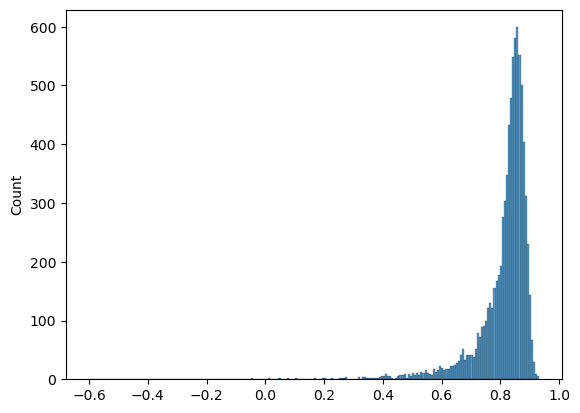

In [80]:
sns.histplot(q)

## Greg debugging log

In [45]:
# get greg log
import json
with open("../mapq_log.json","r") as fh:
    log_dict = json.load(fh)

In [46]:
def point_to_key(point_xyz):
    return str(tuple([str(v) for v in np.round(point_xyz,1)]))

In [48]:
atom_head_key = list(log_dict["atom_pts"].keys())[0]
for rad_key in log_dict["atom_pts"][atom_head_key].keys():
    rad_points = []
    for atom_key in log_dict["atom_pts"].keys():
        points = log_dict["atom_pts"][atom_key][rad_key]
        points = list(np.array(points).astype(float))
        rad_points+=points
    points_to_bild(rad_points,outfile=f"../MapQ_density_rad_{rad_key}.bild")

In [43]:
len(rad_p

array([[103.70658848, 149.50766062, 111.09628571],
       [102.60365059, 151.16627334, 111.382     ],
       [101.53314985, 150.88893046, 111.52485714],
       [102.23736423, 148.27744582, 111.95342857],
       [103.32910884, 148.56072266, 112.09628571],
       [102.5317379 , 151.11303049, 112.52485714],
       [103.23207058, 149.34754833, 113.09628571],
       [102.61588623, 150.37802598, 113.23914286]])

In [31]:
i = 2 # atom index
rs = np.arange(0.1,2.1,0.1)
for i in range(atoms_xyz.shape[0]):
    atom_key = point_to_key(atoms_xyz[i])
    assert atom_key in log_dict["atom_pts"]
    rads_greg = np.array([float(s) for s in sorted(list(log_dict["atom_pts"][atom_key].keys()))])
    assert np.all(np.isclose(rs,rads_greg))
    pts_greg = [] # should be n_probes*n_shells at the end
    for r in rads_greg:
        rad_key = str(round(r,3))
        assert rad_key in log_dict["atom_pts"][atom_key]
        pts = []
        for pt in log_dict["atom_pts"][atom_key][rad_key]:
            pts.append([float(v) for v in pt])
        
        pts_greg.append(np.array(pts))
    pts_greg = stack_fill(pts_greg,dim=0,max_to_shape=11)[:,None,...]
    
    for shell_i,r in enumerate(rads_greg):
        assert np.all(np.isclose(p_greg[shell_i],p_me[shell_i])), "Failed atom_i: {i}"

NameError: name 'p_greg' is not defined

## Compare to greg bfactor column

In [84]:
# compare to gregs
dm = DataManager()
dm.process_model_file("/Users/user/Dropbox/Mac/Desktop/qscore2/clutter/data/6cvm_chainA_prot_B100.pdb")
ref_model = dm.get_model()
ref_q = 1-(ref_model.get_atoms().extract_b().as_numpy_array()/100)


<Axes: ylabel='Count'>

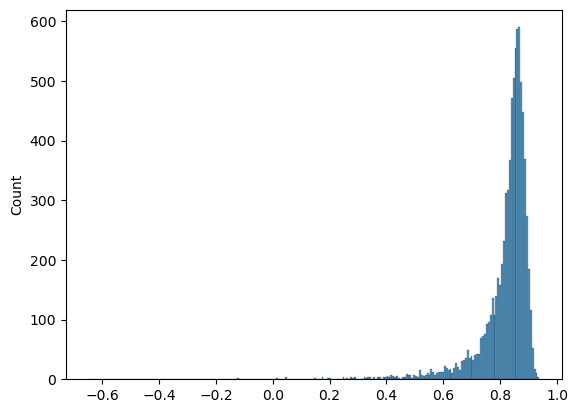

In [85]:
sns.histplot(ref_q)

In [86]:
n_empty_shells = (~np.any(keep_mask.reshape(-1,probe_xyz.shape[2]),axis=1)).sum() # Number of atom shells total without any probes
print("n empty shells: ",n_empty_shells)

n empty shells:  7


In [87]:
i = 0
points_to_bild(probe_xyz[:,0,:8,:].reshape(-1,3),outfile="AA_GREG_Style_probes.bild")

probes_kept = probe_xyz[:,i,:,:][keep_mask[:,i,:]]
points_to_bild(probes_kept,outfile="AA_GREG_Style_KEEP.bild")

1451
0.0072200513605205525


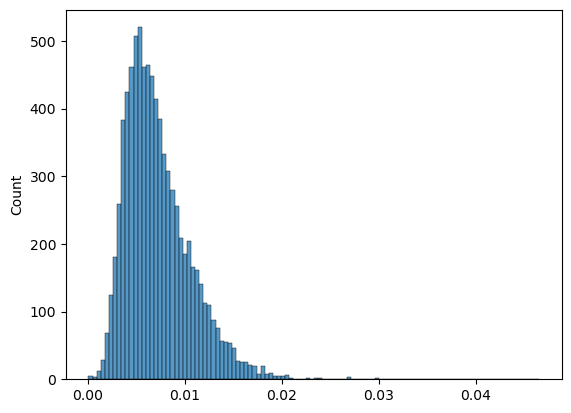

In [88]:
error = np.abs(q-ref_q)
sns.histplot(error)
bad = np.argsort(error)[-1]
print(bad)
print(error.mean())

In [89]:
# def detrend(x,y):
#     # return a new y, detrended with x
#     mean_difference = np.mean(x - y)
#     y_corrected = y + mean_difference
#     return y_corrected

CC: 0.9994613593174309


Text(37.597222222222214, 0.5, 'CCatoms')

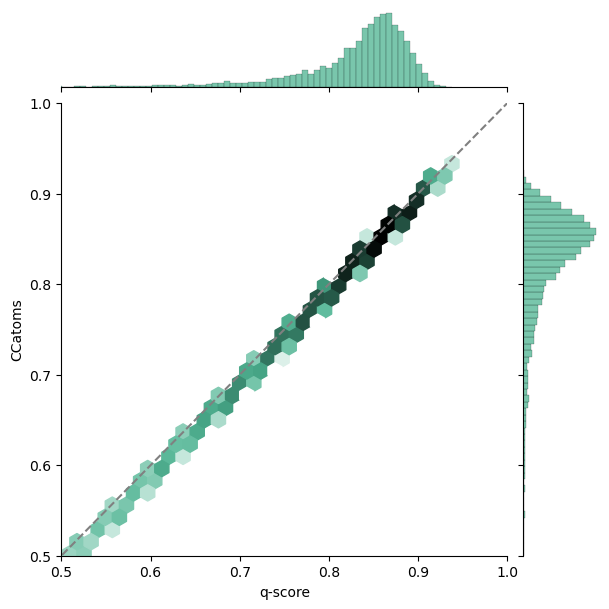

In [90]:
from matplotlib.colors import LogNorm

x,y = ref_q,q
print("CC:",np.corrcoef(x,y)[0][1])
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 100})
fig.ax_joint.collections[0].set_norm(LogNorm())
#fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
#plt.xlim(0.5,1)
#plt.ylim(0.5,1)
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.xlabel("q-score")
plt.ylabel("CCatoms")

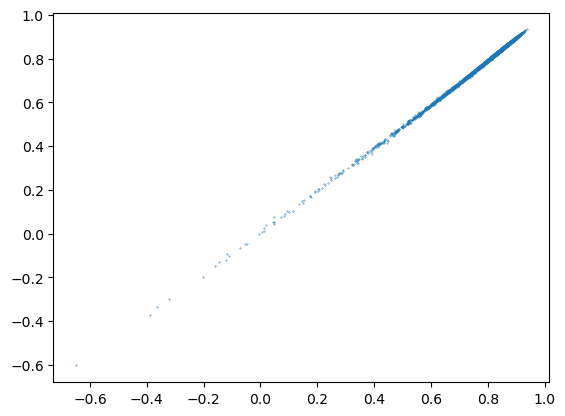

In [59]:
plt.scatter(x,y,s=0.1)

array([0.20238461, 0.74585655, 0.83465807, ..., 0.71217339, 0.60529532,
       0.83964157])

In [62]:
ref_q

array([0.2014, 0.7567, 0.8416, ..., 0.7203, 0.6191, 0.846 ])

In [37]:
i = 10
s = 5
x_repeat = np.repeat(rs,keep_mask.shape[-1])
jitter = np.random.standard_normal(x_repeat.shape[0])*0.01
mask= keep_mask[:,i,:].ravel()
plt.scatter(x_repeat[mask]+jitter[mask],d_vals[:,i].ravel()[mask],s=s)
plt.scatter(x_repeat,g_vals[:,i].ravel(),s=s)

NameError: name 'd_vals' is not defined

In [34]:
mask.shape

(280,)

In [36]:
x_repeat.shape

(20, 8193, 14)

<Axes: ylabel='Count'>

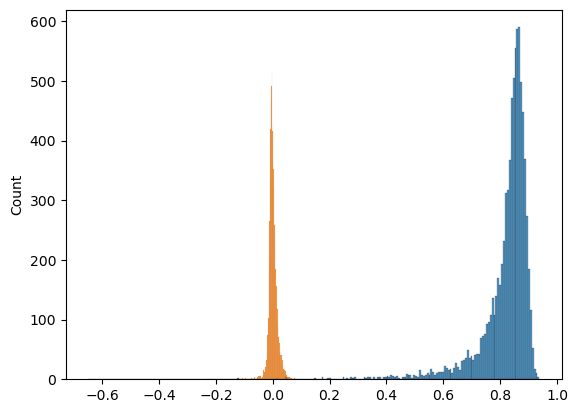

In [130]:
sns.histplot(x)
sns.histplot(y)

In [77]:
def within_sel(model,selection="all",r=10):
    xyz = model.get_sites_cart().as_numpy_array()
    if isinstance(selection,str):
        selection = model.selection(selection)
        
    xyz_query = model.select(selection).get_sites_cart().as_numpy_array()
    tree = KDTree(xyz)
    ret = tree.query_ball_point(xyz_query,r=r)
    from itertools import chain
    return np.array(list(set(list(chain.from_iterable(ret)))))

In [78]:
i = 0
probes_kept = probe_xyz[:,i,:,:][keep_mask[:,i,:]]
points_to_bild(probes_kept,outfile="AA_DEBUG_MY_PROBES.bild")
s = np.full(model.get_number_of_atoms(),False)
s[i] = True
bad_within_sel = within_sel(model,selection=flex.bool(s),r=2.5)
s = np.full(model.get_number_of_atoms(),False)
s[bad_within_sel] = True
dm.write_model_file(model.select(flex.bool(s)),"debug_worst_q_diff.pdb",overwrite=True)

'debug_worst_q_diff.pdb'

In [79]:
# run mapq first , then run this
import json
#points_to_bild(probes_xyz_flat[keep_mask_flat],outfile="AA_my_points.bild")
for i in range(20):
    with open("../mapq_points_shell"+str(i)+"_mapq.json","r") as fh:
        pts = json.load(fh)
        points_to_bild(pts,outfile="../points_"+str(i)+"_mapq.bild")

In [279]:
sel =model.selection("all").as_numpy_array()
x,y = ref_q[sel],q[sel]
print("CC:",np.corrcoef(x,y)[0][1])
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 200})
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
#plt.xlim(0.5,1)
#plt.ylim(0.5,1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("q-score")
plt.ylabel("q-score2")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 37062

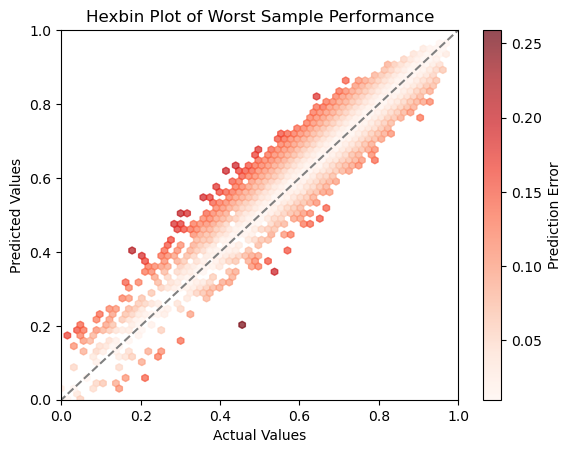

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# see bad samples
y_true = x
y_pred = y

# Calculate prediction errors
errors = np.abs(y_true - y_pred)

# Sort errors and get corresponding indices
sorted_indices = np.argsort(errors)
sorted_errors = errors[sorted_indices]
sorted_true = y_true[sorted_indices]
sorted_pred = y_pred[sorted_indices]

cmap = plt.colormaps["Reds"]
plt.hexbin(sorted_true, sorted_pred, C=sorted_errors, cmap=cmap, gridsize=100, vmin=0.01, alpha=0.7)
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')

# Set colorbar
cbar = plt.colorbar()
cbar.set_label('Prediction Error')

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Hexbin Plot of Worst Sample Performance')

# Show the plot
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


In [280]:
error = np.abs(y-x)
sns.histplot(error)

ValueError: operands could not be broadcast together with shapes (37062,) (1344,) 

In [200]:
error = np.abs(x-y)
worst = np.argsort(error)[-2]

In [201]:
print(error[worst])

0.25064489798845235


In [219]:
ref_q[worst]

0.45810000000000006

In [220]:
q[worst]

0.20745510201154768

In [202]:
worst_atom = model.get_atoms()[worst]


In [324]:
selection

array([ True,  True,  True, ...,  True,  True,  True])

In [325]:
dm.write_model_file(model.select(flex.bool(selection)).model_as_pdb(),"debug_worst_q_diff.pdb",overwrite=True)

'debug_worst_q_diff.pdb'

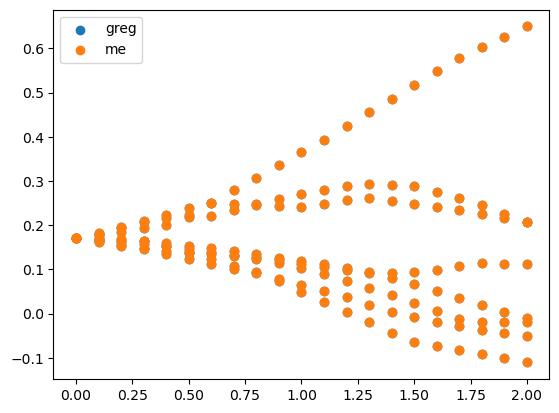

In [290]:
# compare to greg
worst = 0
import json
with open("../dvals_mapq.json","r") as fh:
    d_vals_greg = json.load(fh)
with open("../gvals_mapq.json","r") as fh:
    g_vals_greg = json.load(fh)


x_greg = np.repeat(np.arange(0,2.1,0.1),8)
plt.scatter(x_greg,d_vals_greg,label="greg")
plt.scatter(x_me,d_vals_2d[worst],label="me")

plt.legend()




(-0.1, 0.6)

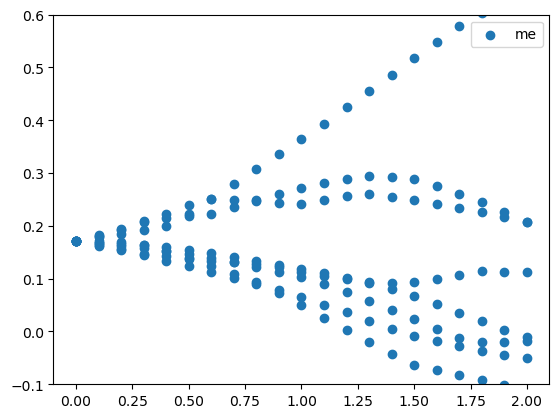

In [291]:
plt.scatter(x_me[mask_2d[worst]],d_vals_2d[worst][mask_2d[worst]],label="me")
plt.legend()
plt.ylim(-0.1,0.6)

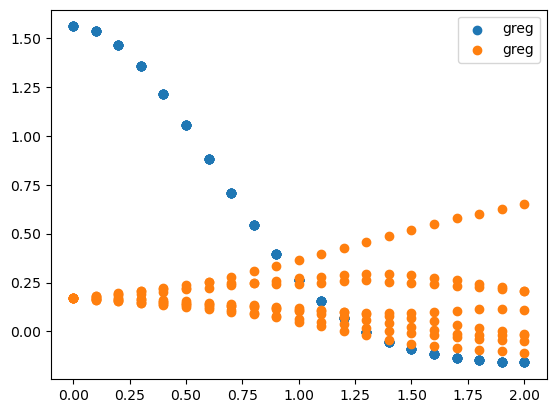

In [292]:
x_greg = np.repeat(np.arange(0,2.1,0.1),8)

#plt.scatter(x_me,d_vals_2d[worst],label="me")
#plt.scatter(x_me,d_vals_2d[100])
plt.scatter(x_greg,g_vals_greg,label="greg")
plt.scatter(x_greg,d_vals_greg,label="greg")
plt.legend()


In [297]:
print(np.corrcoef(d_vals_greg,g_vals_greg))
print(np.corrcoef(d_vals_2d[0],g_vals_2d[0]))
      

[[1.         0.09641045]
 [0.09641045 1.        ]]
[[1.         0.09641231]
 [0.09641231 1.        ]]


In [298]:
worst

0

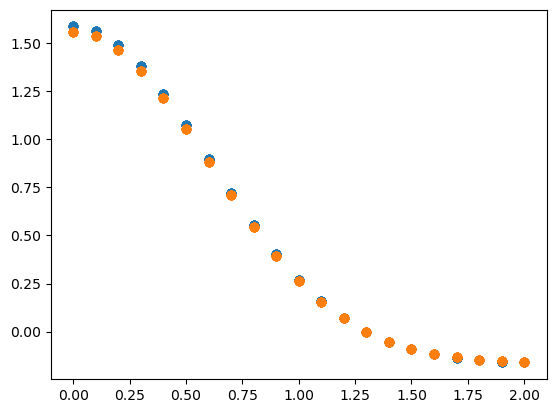

In [293]:
plt.scatter(x_me,g_vals_2d[0])
plt.scatter(x_greg,g_vals_greg)

In [294]:
min_max_normalize

<function __main__.min_max_normalize(distribution)>

In [295]:
x = np.arange(d_vals_2d.shape[1])
a,b = d_vals_2d[worst][mask_2d[worst]],g_vals_2d[worst][mask_2d[worst]]
c = 
plt.scatter(x[mask_2d[worst]],a,label="me_d")
plt.scatter(x[mask_2d[worst]],b,label="me_g")
print(np.corrcoef(d_vals_2d[worst][mask_2d[worst]],g_vals_2d[worst][mask_2d[worst]]))

SyntaxError: invalid syntax (2071828508.py, line 3)

In [251]:
N = np.arange(mask_2d[worst].sum())
s = np.random.choice(N,size=len(N)//4,replace=False)

In [252]:
a = a[s]
b = b[s]

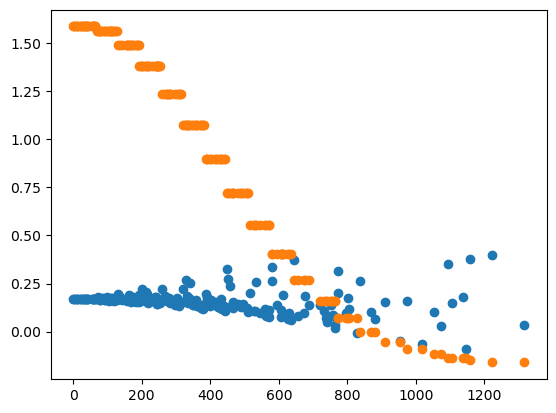

In [254]:
plt.scatter(x[mask_2d[worst]][s],a)
plt.scatter(x[mask_2d[worst]][s],b)

In [296]:
np.corrcoef(a,b)

array([[1.        , 0.23344989],
       [0.23344989, 1.        ]])

In [258]:
np.corrcoef(d_vals_greg,g_vals_greg)

array([[1.        , 0.09641045],
       [0.09641045, 1.        ]])

In [260]:
error[worst]

0.25064489798845235

In [193]:
len(d_vals_2d[worst][keep_mask[worst]])

1344

In [194]:
keep_mask[worst]

array([ True,  True,  True, ...,  True,  True,  True])

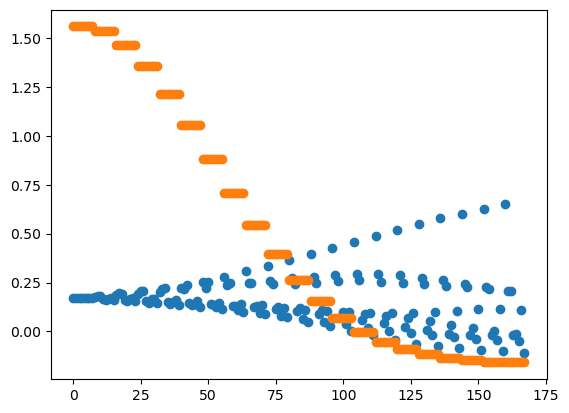

In [181]:
x = np.arange(len(d_vals_greg))
plt.scatter(x,d_vals_greg,label="greg")
plt.scatter(x,g_vals_greg)

In [176]:
print(np.corrcoef(d_vals_2d[worst],g_vals_2d[worst])[0][1])
print(np.corrcoef(d_vals_greg,g_vals_greg)[0][1])

0.695667685077727
0.09641044581681556


In [331]:
#points_to_bild(probes_xyz_flat[keep_mask_flat],outfile="AA_my_points.bild")
for i in range(20):
    with open("../points_"+str(i)+"_mapq.json","r") as fh:
        pts = json.load(fh)
        points_to_bild(pts,outfile="../points_"+str(i)+"_mapq.bild")

In [285]:
# run

# create two arrays, one for the probes and one a mask to decide what probes to use
# Shape probe_xyz: (n_shells,n_atoms,n_probes,3) 
# Shape keep_mask: (n_shells,n_atoms,n_probes)

n_shells = 20
n_probes = 8
radius=2

rads = np.linspace(0,radius,n_shells)
probe_xyz,keep_mask = radial_shell_mp(atoms_xyz,n_shells=n_shells,radii=rads,n_probes=n_probes,num_processes=multiprocessing.cpu_count())
n_shells,n_atoms,n_probes,_ = probe_xyz.shape

In [286]:
g_vals_greg = np.array([9.99394020836,9.99394020836,9.99394020836,9.99394020836,9.99394020836,9.99394020836,9.99394020836,9.99394020836,9.85486714442,9.85486714442,9.85486714442,9.85486714442,9.85486714442,9.85486714442,9.85486714442,9.85486714442,9.44905179771,9.44905179771,9.44905179771,9.44905179771,9.44905179771,9.44905179771,9.44905179771,9.44905179771,8.80916140064,8.80916140064,8.80916140064,8.80916140064,8.80916140064,8.80916140064,8.80916140064,8.80916140064,7.98478379132,7.98478379132,7.98478379132,7.98478379132,7.98478379132,7.98478379132,7.98478379132,7.98478379132,7.0360870858,7.0360870858,7.0360870858,7.0360870858,7.0360870858,7.0360870858,7.0360870858,7.0360870858,6.0266053371,6.0266053371,6.0266053371,6.0266053371,6.0266053371,6.0266053371,6.0266053371,6.0266053371,5.01634291617,5.01634291617,5.01634291617,5.01634291617,5.01634291617,5.01634291617,5.01634291617,5.01634291617,4.05621010867,4.05621010867,4.05621010867,4.05621010867,4.05621010867,4.05621010867,4.05621010867,4.05621010867,3.18443933464,3.18443933464,3.18443933464,3.18443933464,3.18443933464,3.18443933464,3.18443933464,3.18443933464,2.42518998254,2.42518998254,2.42518998254,2.42518998254,2.42518998254,2.42518998254,2.42518998254,2.42518998254,1.7891393901,1.7891393901,1.7891393901,1.7891393901,1.7891393901,1.7891393901,1.7891393901,1.7891393901,1.27556209976,1.27556209976,1.27556209976,1.27556209976,1.27556209976,1.27556209976,1.27556209976,1.27556209976,0.87526020965,0.87526020965,0.87526020965,0.87526020965,0.87526020965,0.87526020965,0.87526020965,0.87526020965,0.573720109539,0.573720109539,0.573720109539,0.573720109539,0.573720109539,0.573720109539,0.573720109539,0.573720109539,0.353996370319,0.353996370319,0.353996370319,0.353996370319,0.353996370319,0.353996370319,0.353996370319,0.353996370319,0.199006857087,0.199006857087,0.199006857087,0.199006857087,0.199006857087,0.199006857087,0.199006857087,0.199006857087,0.0931107170551,0.0931107170551,0.0931107170551,0.0931107170551,0.0931107170551,0.0931107170551,0.0931107170551,0.0931107170551,0.0229936562205,0.0229936562205,0.0229936562205,0.0229936562205,0.0229936562205,0.0229936562205,0.0229936562205,0.0229936562205,-0.0220165200641,-0.0220165200641,-0.0220165200641,-0.0220165200641,-0.0220165200641,-0.0220165200641,-0.0220165200641,-0.0220165200641,-0.0500379796143,-0.0500379796143,-0.0500379796143,-0.0500379796143,-0.0500379796143,-0.0500379796143,-0.0500379796143,-0.0500379796143])

d_vals_greg = [60.2100296021,60.2100296021,60.2100296021,60.2100296021,60.2100296021,60.2100296021,60.2100296021,60.2100296021,59.3695449829,58.7843017578,59.1099624634,58.5824127197,59.3748245239,60.1300048828,60.0598449707,59.3509941101,56.1734542847,56.2653656006,56.1936225891,55.7754974365,55.9782066345,56.324432373,56.7411460876,56.1717796326,51.627571106,51.5634307861,51.8197174072,50.9800491333,52.5587730408,51.4619750977,51.3625640869,51.6180419922,45.6304397583,45.3426895142,45.7713661194,45.3447418213,46.1876220703,45.2598800659,45.404624939,45.5831260681,38.9942092896,39.0398101807,38.6976890564,38.8698616028,39.2277259827,39.2763404846,39.0009536743,39.0838127136,32.319568634,32.3492546082,32.0261955261,32.4109115601,32.2937164307,32.4594955444,32.2360954285,32.1886100769,25.6322517395,25.8997077942,25.7329158783,25.8835201263,25.7897758484,25.6578350067,25.8595752716,25.8595809937,20.1101913452,20.1322479248,19.7998447418,20.1826248169,20.0267467499,19.8745307922,20.0731830597,19.9103965759,14.8590202332,15.1582756042,15.1204376221,14.9623298645,15.0432014465,15.0710639954,15.0315732956,15.1664113998,11.2578010559,11.0553817749,10.9162387848,11.2529659271,11.0154151917,11.089553833,11.1671438217,11.0517129898,7.90338182449,8.05706501007,8.14017105103,7.86175060272,8.15268230438,8.09723758698,8.03535747528,8.18403911591,5.96492242813,5.89131164551,5.82405233383,5.91451644897,5.75672531128,5.86362695694,5.8523106575,5.81229543686,4.13565349579,4.23144054413,4.28684616089,4.16184425354,4.32272958755,4.21784591675,4.32475996017,4.32024097443,3.17019557953,3.11727190018,3.13104963303,3.14602041245,3.08473563194,3.13367271423,3.11520147324,3.08505678177,2.23432946205,2.29230904579,2.28103065491,2.26311063766,2.30860257149,2.27680826187,2.30569195747,2.31287193298,1.67953777313,1.6532715559,1.66510295868,1.67514431477,1.6618219614,1.65097463131,1.67964446545,1.63382256031,1.14653348923,1.17659664154,1.1617898941,1.1717877388,1.17925751209,1.1720584631,1.15744233131,1.18451535702,0.801241993904,0.787228167057,0.798697471619,0.792860150337,0.793262541294,0.775060772896,0.795106947422,0.763286352158,0.483372032642,0.499596208334,0.491930305958,0.501969516277,0.494491159916,0.498335301876,0.505054950714,0.512241721153,0.306803196669,0.306983411312,0.314392924309,0.295612722635,0.303987443447,0.297836214304,0.280897110701,0.271428376436]
# shape (21*8) or 168

greg_points = [[(10.295, 6.159, 7.414000000000001), (10.277830684192804, 6.226846693201557, 7.442571428571429), (10.204981443152555, 6.151258893539956, 7.4711428571428575), (10.275430869246403, 6.061979551181745, 7.499714285714286), (10.382613352803732, 6.112958510256121, 7.5282857142857145), (10.349385039278431, 6.231149378436727, 7.556857142857143), (10.230486445228703, 6.186128590719834, 7.585428571428571), (10.295, 6.159, 7.614)],
[(10.295, 6.159, 7.314), (10.260661368385607, 6.2946933864031145, 7.371142857142857), (10.11496288630511, 6.1435177870799125, 7.428285714285715), (10.255861738492806, 5.9649591023634905, 7.485428571428572), (10.470226705607464, 6.066917020512241, 7.542571428571429), (10.403770078556862, 6.303298756873453, 7.599714285714286), (10.165972890457406, 6.213257181439669, 7.6568571428571435), (10.295, 6.159, 7.714)],
[(10.295, 6.159, 7.214), (10.24349205257841, 6.362540079604671, 7.299714285714286), (10.024944329457664, 6.135776680619869, 7.385428571428571), (10.236292607739209, 5.867938653545236, 7.4711428571428575), (10.557840058411195, 6.020875530768361, 7.556857142857143), (10.458155117835293, 6.3754481353101795, 7.642571428571429), (10.101459335686108, 6.240385772159503, 7.728285714285715), (10.295, 6.159, 7.814)],
[(10.295, 6.159, 7.114), (10.226322736771214, 6.430386772806228, 7.228285714285715), (9.93492577261022, 6.128035574159825, 7.3425714285714285), (10.216723476985612, 5.770918204726981, 7.456857142857143), (10.645453411214927, 5.974834041024482, 7.571142857142857), (10.512540157113724, 6.4475975137469055, 7.685428571428572), (10.036945780914811, 6.267514362879338, 7.799714285714286), (10.295, 6.159, 7.914000000000001)],
[(10.295, 6.159, 7.014), (10.209153420964018, 6.498233466007786, 7.1568571428571435), (9.844907215762774, 6.1202944676997815, 7.299714285714286), (10.197154346232017, 5.673897755908727, 7.442571428571429), (10.733066764018659, 5.928792551280603, 7.585428571428571), (10.566925196392155, 6.519746892183632, 7.728285714285715), (9.972432226143514, 6.294642953599173, 7.871142857142857), (10.295, 6.159, 8.014)],
[(10.295, 6.159, 6.914000000000001), (10.191984105156822, 6.566080159209343, 7.085428571428571), (9.754888658915329, 6.112553361239738, 7.256857142857143), (10.17758521547842, 5.576877307090472, 7.428285714285715), (10.820680116822391, 5.882751061536723, 7.599714285714286), (10.621310235670585, 6.591896270620359, 7.771142857142857), (9.907918671372217, 6.321771544319007, 7.942571428571429), (10.295, 6.159, 8.114)],
[(10.295, 6.159, 6.814), (10.174814789349625, 6.6339268524109, 7.014), (9.664870102067884, 6.104812254779694, 7.214), (10.158016084724823, 5.479856858272218, 7.414000000000001), (10.908293469626123, 5.836709571792844, 7.614), (10.675695274949016, 6.664045649057085, 7.814), (9.84340511660092, 6.348900135038842, 8.014), (10.295, 6.159, 8.214)],
[(10.295, 6.159, 6.714), (10.157645473542429, 6.701773545612458, 6.942571428571429), (9.574851545220438, 6.0970711483196505, 7.171142857142858), (10.138446953971226, 5.3828364094539625, 7.399714285714286), (10.995906822429854, 5.790668082048964, 7.628285714285715), (10.730080314227447, 6.736195027493812, 7.856857142857143), (9.77889156182962, 6.376028725758676, 8.085428571428572), (10.295, 6.159, 8.314)],
[(10.295, 6.159, 6.614000000000001), (10.140476157735232, 6.7696202388140145, 6.871142857142857), (9.484832988372993, 6.089330041859607, 7.128285714285714), (10.118877823217629, 5.285815960635708, 7.385428571428572), (11.083520175233586, 5.744626592305085, 7.642571428571429), (10.784465353505878, 6.808344405930538, 7.899714285714286), (9.714378007058324, 6.40315731647851, 8.156857142857143), (10.295, 6.159, 8.414)],
[(10.295, 6.159, 6.514), (10.123306841928036, 6.837466932015571, 6.799714285714286), (9.394814431525548, 6.081588935399564, 7.085428571428571), (10.099308692464032, 5.188795511817453, 7.371142857142857), (11.171133528037318, 5.698585102561205, 7.6568571428571435), (10.838850392784309, 6.880493784367265, 7.942571428571429), (9.649864452287026, 6.430285907198345, 8.228285714285715), (10.295, 6.159, 8.514)],
[(10.295, 6.159, 6.414000000000001), (10.10613752612084, 6.905313625217128, 6.728285714285715), (9.304795874678103, 6.07384782893952, 7.042571428571429), (10.079739561710435, 5.091775062999199, 7.356857142857143), (11.25874688084105, 5.652543612817326, 7.671142857142858), (10.89323543206274, 6.952643162803991, 7.985428571428572), (9.58535089751573, 6.45741449791818, 8.299714285714286), (10.295, 6.159, 8.614)],
[(10.295, 6.159, 6.314), (10.088968210313643, 6.973160318418686, 6.656857142857143), (9.214777317830658, 6.066106722479477, 6.999714285714286), (10.060170430956838, 4.994754614180944, 7.3425714285714285), (11.346360233644782, 5.606502123073446, 7.685428571428572), (10.947620471341171, 7.024792541240718, 8.028285714285715), (9.520837342744432, 6.484543088638015, 8.371142857142857), (10.295, 6.159, 8.714)],
[(10.295, 6.159, 6.214), (10.071798894506447, 7.041007011620243, 6.585428571428571), (9.124758760983212, 6.058365616019433, 6.956857142857143), (10.04060130020324, 4.897734165362689, 7.328285714285714), (11.433973586448513, 5.560460633329567, 7.699714285714286), (11.002005510619602, 7.096941919677445, 8.071142857142858), (9.456323787973135, 6.511671679357849, 8.442571428571428), (10.295, 6.159, 8.814)],
[(10.295, 6.159, 6.114), (10.05462957869925, 7.108853704821801, 6.514), (9.034740204135767, 6.050624509559389, 6.914), (10.021032169449645, 4.8007137165444345, 7.314), (11.521586939252245, 5.5144191435856875, 7.714), (11.056390549898033, 7.1690912981141715, 8.114), (9.391810233201838, 6.538800270077683, 8.514), (10.295, 6.159, 8.914)],
[(10.295, 6.159, 6.014), (10.037460262892054, 7.176700398023358, 6.442571428571428), (8.944721647288322, 6.042883403099346, 6.871142857142857), (10.001463038696048, 4.70369326772618, 7.299714285714286), (11.609200292055977, 5.4683776538418085, 7.728285714285715), (11.110775589176464, 7.241240676550897, 8.156857142857143), (9.32729667843054, 6.565928860797518, 8.585428571428572), (10.295, 6.159, 9.014000000000001)],
[(10.295, 6.159, 5.914), (10.020290947084858, 7.244547091224915, 6.371142857142857), (8.854703090440877, 6.035142296639302, 6.828285714285714), (9.981893907942451, 4.606672818907925, 7.285428571428572), (11.69681364485971, 5.422336164097929, 7.742571428571429), (11.165160628454895, 7.313390054987624, 8.199714285714286), (9.262783123659244, 6.593057451517352, 8.656857142857143), (10.295, 6.159, 9.114)],
[(10.295, 6.159, 5.814), (10.003121631277661, 7.312393784426472, 6.299714285714286), (8.764684533593432, 6.027401190179258, 6.785428571428572), (9.962324777188854, 4.50965237008967, 7.271142857142857), (11.784426997663441, 5.37629467435405, 7.756857142857143), (11.219545667733325, 7.38553943342435, 8.242571428571429), (9.198269568887946, 6.620186042237187, 8.728285714285715), (10.295, 6.159, 9.214)],
[(10.295, 6.159, 5.7139999999999995), (9.985952315470465, 7.380240477628029, 6.228285714285714), (8.674665976745986, 6.019660083719215, 6.742571428571429), (9.942755646435257, 4.412631921271416, 7.256857142857143), (11.872040350467174, 5.33025318461017, 7.771142857142857), (11.273930707011756, 7.457688811861077, 8.285428571428572), (9.13375601411665, 6.647314632957022, 8.799714285714286), (10.295, 6.159, 9.314)],
[(10.295, 6.159, 5.614), (9.968782999663269, 7.448087170829586, 6.156857142857143), (8.584647419898541, 6.011918977259171, 6.699714285714285), (9.92318651568166, 4.315611472453161, 7.242571428571429), (11.959653703270906, 5.28421169486629, 7.785428571428572), (11.328315746290187, 7.529838190297804, 8.328285714285714), (9.06924245934535, 6.674443223676856, 8.871142857142857), (10.295, 6.159, 9.414000000000001)],
[(10.295, 6.159, 5.513999999999999), (9.951613683856072, 7.515933864031144, 6.085428571428571), (8.494628863051096, 6.004177870799127, 6.656857142857143), (9.903617384928063, 4.2185910236349065, 7.228285714285715), (12.047267056074636, 5.238170205122411, 7.799714285714286), (11.382700785568618, 7.60198756873453, 8.371142857142857), (9.004728904574053, 6.701571814396691, 8.942571428571428), (10.295, 6.159, 9.514000000000001)]]

greg_points = np.array(greg_points)[:,None]
print(greg_points.shape)
probe_xyz_greg = greg_points
n_shells,n_atoms,n_probes,_ = probe_xyz_greg.shape
# for i,shell in enumerate(greg_points):
#    points_to_bild(shell,outfile=f"greg_shell_{i}.bild")
#assert probe_xyz_greg.shape == probe_xyz.shape

(20, 1, 8, 3)


In [287]:

ignore_min_probes = True
if not ignore_min_probes:
    # calculate the minimum probe number for each atom, fail if probes within a cutoff radius have less than specified
    shell_min_count = keep_mask.sum(axis=-1).min(axis=1)
    absolute_diff = np.abs(rs - min_rad)
    nearest_index = np.argmin(absolute_diff)
    r_cutoff = rs[nearest_index]
    if shell_min_count[nearest_index]<min_probes:
        assert  False, "At least one atom has less than the specified min probes after removing clashes. Try adding more probes or reducing min_probe param."





# interpolate density 
probe_xyz_flat = probe_xyz.reshape((n_atoms*n_shells*n_probes,3))
probe_xyz_flat_greg = probe_xyz_greg.reshape((n_atoms*n_shells*n_probes,3))
probe_xyz_flat_flex = flex.vec3_double(probe_xyz_flat)
probe_xyz_flat_flex_greg = flex.vec3_double(probe_xyz_flat_greg)
#density = trilinear_interpolation(volume,,voxel_size=voxel_size)
density = mm.density_at_sites_cart(probe_xyz_flat_flex).as_numpy_array()
density_greg = mm.density_at_sites_cart(probe_xyz_flat_flex_greg).as_numpy_array()
d_vals= density.reshape((n_shells,n_atoms,n_probes))
d_vals_greg_me= density_greg.reshape((n_shells,n_atoms,n_probes))
# # Create an array for the indices that combines all dimensions but the last one
# indices_for_d_vals = (indices[0], indices[1], indices[2])


# # initialize density array
# d_vals = np.zeros(keep_mask.shape)

# # Put the result back to d_vals
# d_vals[indices_for_d_vals] = density

ValueError: cannot reshape array of size 17789760 into shape (160,3)

In [ ]:
# get reference gaussian

rads = np.linspace(0,2,21)

n_atoms = probe_xyz.shape[1]
n_probes = probe_xyz.shape[2]
M = volume
maxD = min(M.mean()+M.std()*10,M.max())
minD = max(M.mean()-M.std()*1,M.min())
A = maxD-minD
B = minD
u = 0
sigma = 0.6
x = rads
y = A * np.exp(-0.5*((x-u)/sigma)**2) + B 

# stack the reference to shape (n_shells,n_atoms,n_probes)
g_vals = np.repeat(y[:,None],n_probes,axis=1)
x_repeat = np.repeat(x,n_probes)
g_vals = np.expand_dims(g_vals,1)

g_vals = np.tile(g_vals,(n_atoms,1))

# Reshape to 2d for masked rowwise correlation calculation
g_vals_2d = g_vals.transpose(1,0,2).reshape(g_vals.shape[1], -1)
d_vals_2d = d_vals.transpose(1,0,2).reshape(d_vals.shape[1], -1)
d_vals_2d_greg_me = d_vals_greg_me.transpose(1,0,2).reshape(d_vals_greg_me.shape[1], -1)
#d_vals_2d = 
#keep_mask_2d = keep_mask.transpose(1,0,2).reshape(keep.shape[1], -1)

In [ ]:
print(A,B)

In [ ]:
# plot gregs 2
# ('A:', 10.082958098749494)
# ('B:', -0.08901789)
# ('sigma:', 0.6)

plt.plot(g_vals_greg)
plt.plot(d_vals_greg)

In [ ]:
# compare ref with mine
plt.plot(g_vals_greg,label="greg")
plt.plot(g_vals_2d[0],label="me")
plt.legend()

In [ ]:
def pad_arr_custom(arr):
    max_value = np.max(arr)  # Compute the maximum value of the entire array
    extra_row = np.full((1, 1, 8), max_value)  # Create an array with the maximum value
    expanded_array = np.concatenate((extra_row,arr), axis=0) 
    return expanded_array

In [233]:
d_vals_pad = pad_arr_custom(d_vals)
d_vals_2d_pad = d_vals_pad.transpose(1,0,2).reshape(d_vals_pad.shape[1], -1)

d_vals_greg_me_pad = pad_arr_custom(d_vals_greg_me)
d_vals_greg_me_2d_pad = d_vals_greg_me_pad.transpose(1,0,2).reshape(d_vals_greg_me_pad.shape[1], -1)

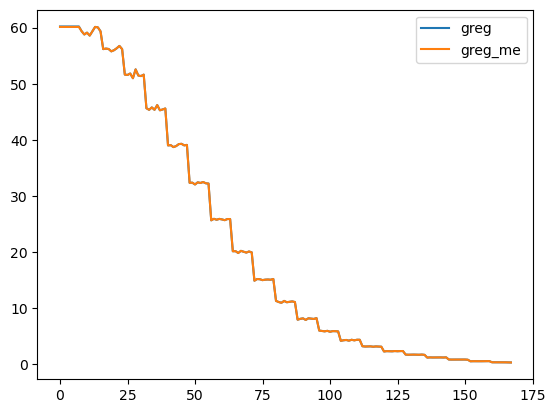

In [234]:
# compare density for gregs points with mine
plt.plot(d_vals_greg,label="greg")
plt.plot(d_vals_greg_me_2d_pad[0],label="greg_me")
#plt.plot(np.concatenate([[max(d_vals_2d_greg[0])]*8,d_vals_2d[0]]),label="me")
plt.legend()

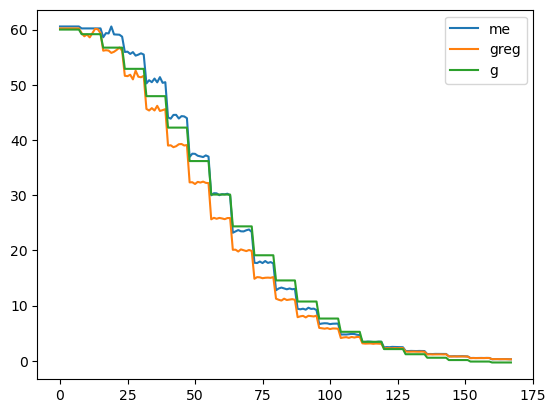

In [239]:
# compare with my probes
plt.plot(d_vals_2d_pad[0],label="me")
plt.plot(d_vals_greg,label="greg")
plt.plot(g_vals_2d[0]*6,label="g")
#plt.plot(d_vals_greg_me_2d_pad[0],label="greg_me")
plt.legend()

In [240]:
print(np.corrcoef(d_vals_greg,g_vals_greg)[0][1])
print(np.corrcoef(d_vals_greg_me_2d_pad[0],g_vals_2d[0])[0][1])
print(np.corrcoef(d_vals_2d_pad[0],g_vals_2d[0])[0][1])

0.9965706210945714
0.9965877562565896
0.9989223076024337


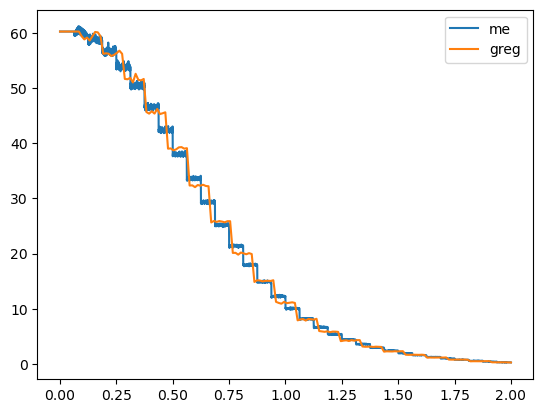

In [277]:
# compare with my probes
rads = np.linspace(0,radius,n_shells*n_probes)
rads_8 = np.linspace(0,radius,8*21)
plt.plot(rads,d_vals_2d[0],label="me")
plt.plot(rads_8,d_vals_greg,label="greg")
#plt.plot(g_vals_2d[0]*6,label="g")
#plt.plot(d_vals_greg_me_2d_pad[0],label="greg_me")
plt.legend()

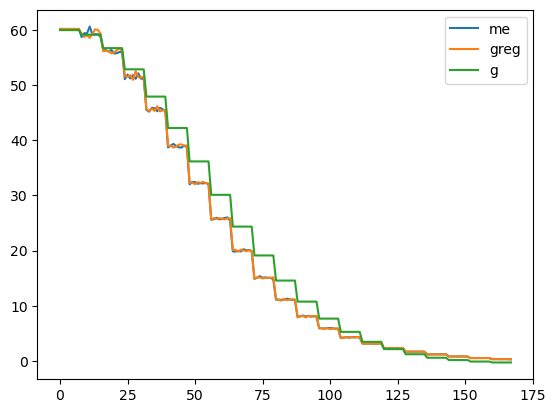

In [248]:
# compare with my probes
plt.plot(d_vals_2d[0],label="me")
plt.plot(d_vals_greg,label="greg")
plt.plot(g_vals_2d[0]*6,label="g")
#plt.plot(d_vals_greg_me_2d_pad[0],label="greg_me")
plt.legend()

In [102]:
x_tile = np.repeat(x[:,None],n_probes,axis=1)
print(x_tile.shape)

(21, 32)


In [103]:
atom_i = 1000
shell_i =10
mask_i = keep_mask[:,atom_i]

y = d_vals[:,atom_i][mask_i]
x = x_tile[mask_i]

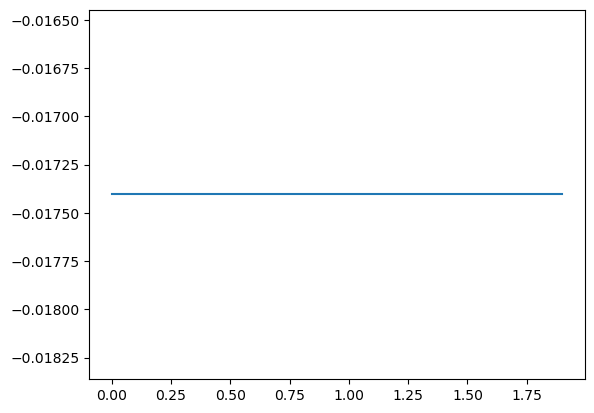

In [104]:
plt.plot(x,y)

<Axes: ylabel='Count'>

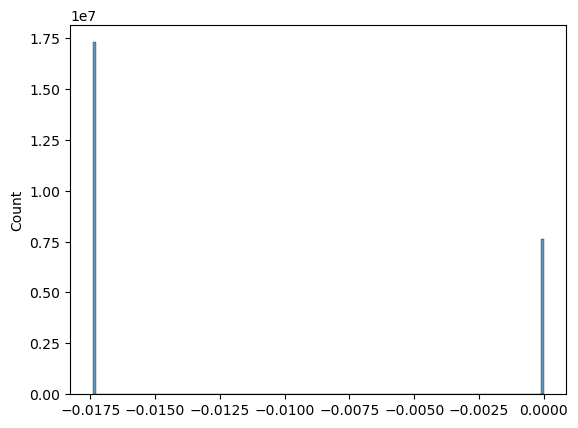

In [110]:
sns.histplot(d_vals.flatten())

In [37]:
# def calculate_q(volume,atoms_xyz,voxel_size,n_probes,n_shells,rtol=0.05,radius=2.0,min_probes=4,min_rad=1.2,ignore_min_probes=False,selection_mask=None):

#     # if a mask is provided, apply that, but it is important that non-masked atoms be present for probe clashes
#     if selection_mask is None:
#         sel = np.full(atoms_xyz.shape[0],True)
#     else:
#         sel = selection_mask
#     n_atoms = atoms_xyz[sel].shape[0]

    
#     rs = np.linspace(0,radius,n_shells)
#     probe_xyz = np.empty((n_shells,n_atoms,n_probes,3))
#     keep = np.empty((n_shells,n_atoms,n_probes),dtype=bool)
#     kdtree_atoms = KDTree(atoms_xyz)
    
#     for i,r in enumerate(tqdm(rs)):
#         # get a set of probes at a radius around zero
#         unit_probes = radial_points(samples=n_probes,rad=r)
#         n_probes = unit_probes.shape[0]
        
#         # broadcast to each atom and translate to atom center
#         probe_xyz_r = (atoms_xyz[sel][:,np.newaxis,:]+unit_probes[np.newaxis,:]) # (n_atoms,n_probes,3)
        
#         # query kdtree to find probe-atom interactions (the slowest part by far)
#         counts = kdtree_atoms.query_ball_point(probe_xyz_r,r+rtol,return_length=True) #  (n_atoms,n_probes) (a count value for each probe)
#         # each value in counts is the number of atoms within radius+tol of each probe
        
#         # Only want to select probes with a single atom neighbor
#         keep_sel = counts==1
    
#         # add this shell to the lists
#         probe_xyz[i] = probe_xyz_r
#         keep[i] = keep_sel

#     if not ignore_min_probes:
#         # calculate the minimum probe number for each atom, fail if probes within a cutoff radius have less than specified
#         shell_min_count = keep.sum(axis=-1).min(axis=1)
#         absolute_diff = np.abs(rs - min_rad)
#         nearest_index = np.argmin(absolute_diff)
#         r_cutoff = rs[nearest_index]
#         if shell_min_count[nearest_index]<min_probes:
#             assert  False, "At least one atom has less than the specified min probes after removing clashes. Try adding more probes or reducing min_probe param."
    

#     # initialize density array
#     d_vals = np.zeros(keep.shape)
    
#     # Get the indices of True values in keep
#     indices = np.where(keep)
    
#     # Apply mask to probe_xyz and pass to your_function
#     masked_probe_xyz = probe_xyz[indices[0], indices[1], indices[2]]
    
#     # interpolate density ONLY at kept probes
#     density = trilinear_interpolation(volume,voxel_size,masked_probe_xyz)


#     # Create an array for the indices that combines all dimensions but the last one
#     indices_for_d_vals = (indices[0], indices[1], indices[2])
    
#     # Put the result back tod_vals
#     d_vals[indices_for_d_vals] = density[:,0]
    
#     # get reference gaussian
#     Mavg = density.mean()
#     Msigma = density.std()
#     A = Mavg + 10*Msigma
#     B = Mavg - 1.0*Msigma
#     u = 0
#     sigma = 0.6
#     x = rs
#     y = A * np.exp(-0.5*((x-u)/sigma)**2) + B 
    
#     # stack the reference to shape (n_shells,n_atoms,n_probes)
#     g_vals = np.repeat(y[:,None],n_probes,axis=1)
#     g_vals = np.expand_dims(g_vals,1)
#     g_vals = np.tile(g_vals,(n_atoms,1))
    
#     # Reshape to 2d for masked rowwise correlation calculation
#     g_vals_2d = g_vals.transpose(1,0,2).reshape(g_vals.shape[1], -1)
#     d_vals_2d = d_vals.transpose(1,0,2).reshape(d_vals.shape[1], -1)
#     keep_2d = keep.transpose(1,0,2).reshape(keep.shape[1], -1)


#     # q is correlation coefficient
#     q = rowwise_corrcoef(g_vals_2d,d_vals_2d,mask=keep_2d)

#     return q

In [33]:
# %%time
# # rewrite qscore
# # Extract objects
# selection = "all"
# voxel_size = mm.pixel_sizes()[0]
# n_shells = 21
# n_probes =64
# volume = mm.map_data().as_numpy_array()
# atoms_xyz = model.get_sites_cart().as_numpy_array()
# # debug_sel = np.full(atoms_xyz.shape[0],False)
# # debug_sel[100:200] = True
# n_atoms= atoms_xyz.shape[0]
# #q_single = calculate_q(volume,atoms_xyz,voxel_size,n_probes,n_shells,ignore_min_probes=True)



CPU times: user 16.1 ms, sys: 83.9 ms, total: 100 ms
Wall time: 101 ms


# MP Version

In [38]:
# from numba import njit
# @njit(parallel=True)
# def trilinear_interpolation(voxel_grid, coords, voxel_size=0.6370000444220368, offset=None):
#     # Apply offset if provided
#     if offset is not None:
#         coords = coords - offset

#     # Transform coordinates to voxel grid index space
#     index_coords = coords / voxel_size

#     # Split the index_coords array into three arrays: x, y, and z
#     x, y, z = index_coords.T

#     # Truncate to integer values
#     x0, y0, z0 = np.floor(x).astype(np.int64), np.floor(y).astype(np.int64), np.floor(z).astype(np.int64)
#     x1, y1, z1 = np.ceil(x).astype(np.int64), np.ceil(y).astype(np.int64), np.ceil(z).astype(np.int64)

#     # Ensure indices are within grid boundaries
#     x0, y0, z0 = np.clip(x0, 0, voxel_grid.shape[0]-1), np.clip(y0, 0, voxel_grid.shape[1]-1), np.clip(z0, 0, voxel_grid.shape[2]-1)
#     x1, y1, z1 = np.clip(x1, 0, voxel_grid.shape[0]-1), np.clip(y1, 0, voxel_grid.shape[1]-1), np.clip(z1, 0, voxel_grid.shape[2]-1)

#     # Compute weights
#     xd, yd, zd = x - x0, y - y0, z - z0

#     # Interpolate
#     c = np.zeros(x.shape[0])
#     for i in range(x.shape[0]):
#         c00 = voxel_grid[x0[i], y0[i], z0[i]]*(1-xd[i]) + voxel_grid[x1[i], y0[i], z0[i]]*xd[i]
#         c01 = voxel_grid[x0[i], y0[i], z1[i]]*(1-xd[i]) + voxel_grid[x1[i], y0[i], z1[i]]*xd[i]
#         c10 = voxel_grid[x0[i], y1[i], z0[i]]*(1-xd[i]) + voxel_grid[x1[i], y1[i], z0[i]]*xd[i]
#         c11 = voxel_grid[x0[i], y1[i], z1[i]]*(1-xd[i]) + voxel_grid[x1[i], y1[i], z1[i]]*xd[i]
#         c0 = c00*(1-yd[i]) + c10*yd[i]
#         c1 = c01*(1-yd[i]) + c11*yd[i]
#         c[i] = c0*(1-zd[i]) + c1*zd[i]

#     return c

# @njit
# def rowwise_corrcoef(A, B, mask=None):
#     assert A.shape == B.shape, "A and B must have the same shape"
    
#     if mask is not None:
#         assert mask.shape == A.shape, "mask must have the same shape as A and B"
#         A = np.where(mask, A, np.nan)
#         B = np.where(mask, B, np.nan)
    
#     n = A.shape[1]
#     output = np.empty(A.shape[0])
    
#     for i in range(A.shape[0]):
#         # Calculate means ignoring NaNs
#         A_mean = np.nanmean(A[i])
#         B_mean = np.nanmean(B[i])
    
#         # Subtract means
#         A_centered = A[i] - A_mean
#         B_centered = B[i] - B_mean
    
#         # Calculate sum of products ignoring NaNs
#         sumprod = np.nansum(A_centered * B_centered)
    
#         # Calculate square roots of the sum of squares ignoring NaNs
#         sqrt_sos_A = np.sqrt(np.nansum(A_centered**2))
#         sqrt_sos_B = np.sqrt(np.nansum(B_centered**2))
    
#         # Return correlation coefficients
#         output[i] = sumprod / (sqrt_sos_A * sqrt_sos_B)
        
#     return output

In [261]:
# args = {"n_shells":21,
#         "n_probes":16,
#         "voxel_size":voxel_size,
#         "radius":2.0,
#         "rtol":0.05,
#         "min_probes":4,
#         "min_rad":1.2,
#         "voxel_size":voxel_size,

#          }
# n_shells = args["n_shells"]
# n_probes = args["n_probes"]
# radius = args["radius"]
# rtol = args["rtol"]
# voxel_size = args["voxel_size"]
# min_rad = args["min_rad"]
# min_probes = args["min_probes"]


In [262]:
# import multiprocessing as mp


In [263]:
# %%time
# # get radial probes
# rs = np.linspace(0,radius,n_shells)
# probe_xyz,keep = radial_shell_mp(atoms_xyz,n_shells=n_shells,n_probes=n_probes,num_processes=mp.cpu_count())




# # calculate the minimum probe number for each atom, fail if probes within a cutoff radius have less than specified
# shell_min_count = keep.sum(axis=-1).min(axis=1)
# absolute_diff = np.abs(rs - min_rad)
# nearest_index = np.argmin(absolute_diff)
# r_cutoff = rs[nearest_index]
# if shell_min_count[nearest_index]<min_probes:
#     assert  False, "At least one atom has less than the specified min probes after removing clashes. Try adding more probes or reducing min_probe param."


# # initialize density array
# d_vals = np.zeros(keep.shape)

# # Get the indices of True values in arr1
# indices = np.where(keep)

# # Apply mask to arr2 and pass to your_function
# masked_probe_xyz = probe_xyz[indices[0], indices[1], indices[2]]

# # interpolate density ONLY at kept probes
# density = trilinear_interpolation(volume,masked_probe_xyz,voxel_size=voxel_size)

# # Create an array for the indices that combines all dimensions but the last one
# indices_for_d_vals = (indices[0], indices[1], indices[2])

# # Put the result back to arr3
# d_vals[indices_for_d_vals] = density

# # get reference gaussian
# Mavg = density.mean()
# Msigma = density.std()
# A = Mavg + 10*Msigma
# B = Mavg - 1.0*Msigma
# u = 0
# sigma = 0.6
# x = rs
# y = A * np.exp(-0.5*((x-u)/sigma)**2) + B 

# # stack the reference to shape (n_shells,n_atoms,n_probes)
# g_vals = np.repeat(y[:,None],n_probes,axis=1)
# g_vals = np.expand_dims(g_vals,1)
# g_vals = np.tile(g_vals,(n_atoms,1))

# # Reshape to 2d for masked rowwise correlation calculation
# g_vals_2d = g_vals.transpose(1,0,2).reshape(g_vals.shape[1], -1)
# d_vals_2d = d_vals.transpose(1,0,2).reshape(d_vals.shape[1], -1)
# keep_2d = keep.transpose(1,0,2).reshape(keep.shape[1], -1)

# # q is correlation coefficient
# q = rowwise_corrcoef(g_vals_2d,d_vals_2d,mask=keep_2d)

AssertionError: At least one atom has less than the specified min probes after removing clashes. Try adding more probes or reducing min_probe param.

# Compare q with cc

In [11]:
my_q = q[:,0]

In [13]:
#my_q = fisher(q_mp)

In [14]:
ref_q = 1-(ref_model.get_atoms().extract_b().as_numpy_array()/100)
#ref_q = fisher(ref_q)

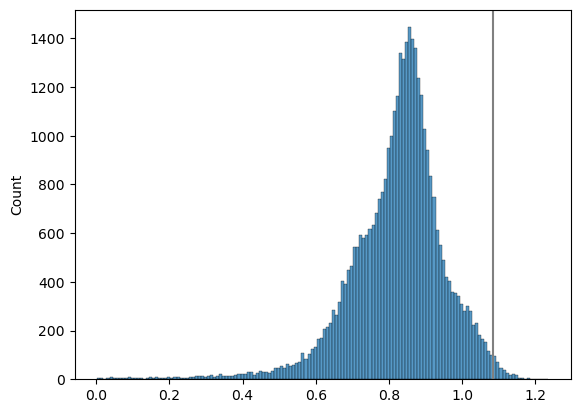

In [15]:
import seaborn as sns
x,y = ref_q,my_q
error = np.abs(x-y)
sns.histplot(error)
plt.axvline(x=np.quantile(error,0.99),color="gray") # 99% are within x% error of gregs q

<Axes: ylabel='Count'>

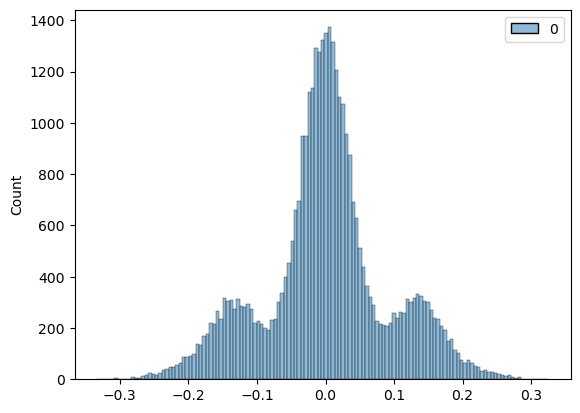

In [16]:
sns.histplot(q)

CC: 0.9508168080939802


Text(37.597222222222214, 0.5, 'q-score2')

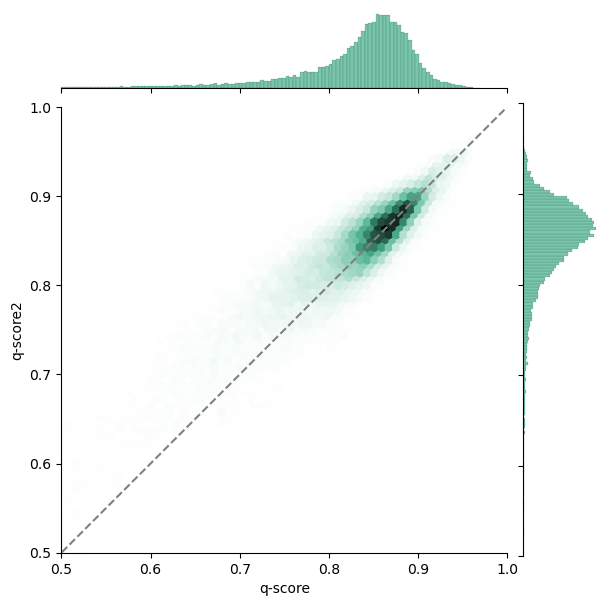

In [252]:
x,y = ref_q,my_q
print("CC:",np.corrcoef(x,y)[0][1])
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 200})
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.xlabel("q-score")
plt.ylabel("q-score2")

In [254]:
np.abs(ref_q-my_q).max()

0.2635482303145164

In [164]:
#%%time
# do ccmask v3

# sel = np.full(atoms_xyz.shape[0],True)
# rs = np.linspace(0,radius,n_shells)
# probes = []
# for i,r in enumerate(rs):
#     # get a set of probes at a radius around zero
#     unit_probes = radial_points_even_density(density=1.0,rad=r)
    
#     # broadcast to each atom and translate to atom center
#     probe_xyz_r = (atoms_xyz[sel][:,np.newaxis,:]+unit_probes[np.newaxis,:]) # (n_atoms,n_probes,3)
#     probe_xyz_r = probe_xyz_r.reshape((np.prod(probe_xyz_r.shape[:2]),3))
#     probes.append(probe_xyz_r)

# density = trilinear_interpolation(volume,probes)
# cc = rowwise_corrcoef(density,density)

/var/folders/z6/pfl9r4bn47b071n0294gyqym0000gn/T/ipykernel_40144/1877123773.py:58: RuntimeWarning: invalid value encountered in divide
  y = 1. - (i / float(samples - 1.)) * 2.


In [179]:
# ccmask pavel
from mmtbx.maps.correlation import from_map_map_atoms_per_atom

d_obs = mmm.map_manager().map_data().as_numpy_array()
mmm.generate_map(d_min=d_min,model=mmm.model(),map_id="calc1")
mmm.generate_map(d_min=d_min+0.1,model=mmm.model(),map_id="calc2")
d_calc1 = mmm.get_map_data_by_id(map_id="calc1").as_numpy_array()
d_calc2 = mmm.get_map_data_by_id(map_id="calc2").as_numpy_array()


cc_atoms = from_map_map_atoms_per_atom(mmm.map_manager().map_data(),
                            mmm.get_map_data_by_id(map_id="calc1"),
                            model.get_sites_cart(),
                            model.unit_cell_crystal_symmetry().unit_cell(),
                            2.0)
cc_atoms_pavel = cc_atoms.as_numpy_array()

Text(37.597222222222214, 0.5, 'CCatom')

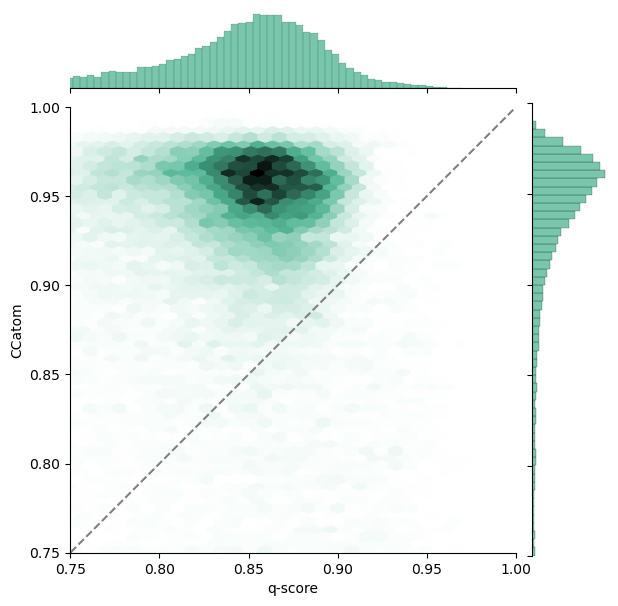

In [264]:
x,y = ref_q,cc_atoms_pavel
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 200})
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
plt.xlim(0.75,1)
plt.ylim(0.75,1)
plt.xlabel("q-score")
plt.ylabel("CCatom")

In [241]:
# get some extremes

low_low = 0
low_high = 0.2
high_low = 0.7
high_high = 1

low, high = np.quantile(ref_q,[low_low,low_high])
ref_q_bad = (low<ref_q) & (ref_q<high)

low, high = np.quantile(cc_atoms_pavel,[high_low,high_high])
ref_q_good = (low<ref_q) & (ref_q<high)

low, high = np.quantile(cc_atoms_pavel,[low_low,low_high])
cc_atoms_bad = (low<cc_atoms) & (cc_atoms<high)

low, high = np.quantile(cc_atoms_pavel,[high_low,high_high])
cc_atoms_good = (low<cc_atoms) & (cc_atoms<high)

In [242]:
# ref_q is on left in variable names
good_good = ref_q_good & cc_atoms_good
good_bad = ref_q_good & cc_atoms_bad
bad_good = ref_q_bad & cc_atoms_good
bad_bad = ref_q_bad & cc_atoms_bad

In [243]:
# select and write
model_good_good = model.select(flex.bool(good_good))
print("good_good:",model_good_good.get_number_of_atoms())
model_good_bad = model.select(flex.bool(good_bad))
print("good_bad:",model_good_bad.get_number_of_atoms())
model_bad_good = model.select(flex.bool(bad_good))
print("bad_good:",model_bad_good.get_number_of_atoms())
model_bad_bad = model.select(flex.bool(bad_bad))
print("bad_bad:",model_bad_bad.get_number_of_atoms())


good_good: 0
good_bad: 14
bad_good: 1296
bad_bad: 2748


In [232]:
dm.write_model_file(model_good_good.model_as_pdb(),"../figures/refq_good_ccatoms_good.pdb",overwrite=True)
dm.write_model_file(model_good_bad.model_as_pdb(),"../figures/refq_good_ccatoms_bad.pdb",overwrite=True)
dm.write_model_file(model_bad_good.model_as_pdb(),"../figures/refq_bad_ccatoms_good.pdb",overwrite=True)
dm.write_model_file(model_bad_bad.model_as_pdb(),"../figures/refq_bad_ccatoms_bad.pdb",overwrite=True)

'../figures/refq_bad_ccatoms_bad.pdb'

In [249]:
mm = mmm.get_map_manager_by_id(map_id="calc1")
mm.write_map("../figures/6cvm_calc.mrc")

(0.0, 3.0)

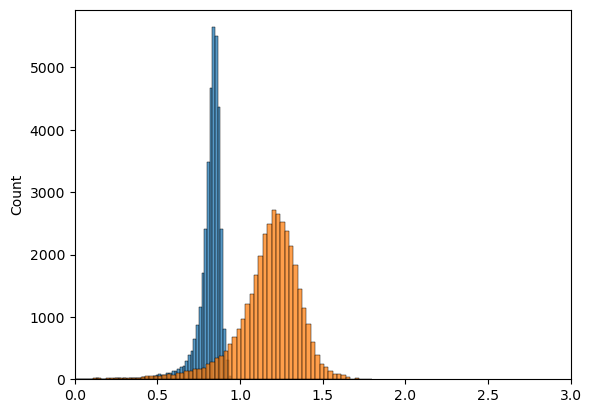

In [105]:
bins = 100
sns.histplot(my_q,bins=bins)
sns.histplot(fisher(my_q),bins=bins)
plt.xlim(0,3)

In [102]:
my_q.shape

(37062,)

(0.0, 3.0)

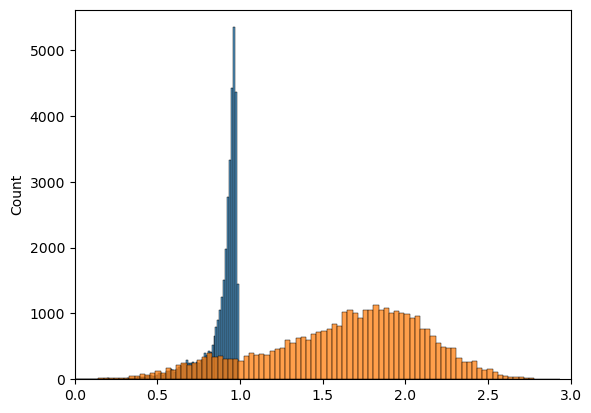

In [106]:
sns.histplot(cc_atoms_pavel,bins=bins)
sns.histplot(fisher(cc_atoms_pavel),bins=bins)
plt.xlim(0,3)

In [187]:
# Run parallel numpy 

# Create a queue to hold the tasks
queue = mp.JoinableQueue()

# Now you can manually create each subprocess
processes = []
nproc = 10
for _ in range(nproc):
    p = mp.Process(target=worker_fn, args=(
                            input_array_shared,
                            input_shape,
                            output_array_shared,
                            output_shape,
                            num_chunks, 
                            overlap,
                            function,
                            axes))
    p.start()
    processes.append(p)

# Now you can add tasks to the queue
for i in work:
    queue.put(i)

# Add a 'STOP' message for each worker
for _ in range(nproc):
    queue.put('STOP')

# Wait for all tasks in the queue to be processed
queue.join()

# Wait for all processes to finish
for p in processes:
    p.join()

NameError: name 'mask_shared' is not defined

In [185]:
args = parallelize_computation(np.random.random((1000,100)),32,8,f,1)

In [186]:
pad = 8
n_chunks = 4
args = parallelize_computation(volume,n_chunks,pad,f,(0,1,2))

In [172]:
len(args)

64

100

In [174]:
args[0][0].shape

(100, 100, 100)

Text(37.597222222222214, 0.5, 'CCatom')

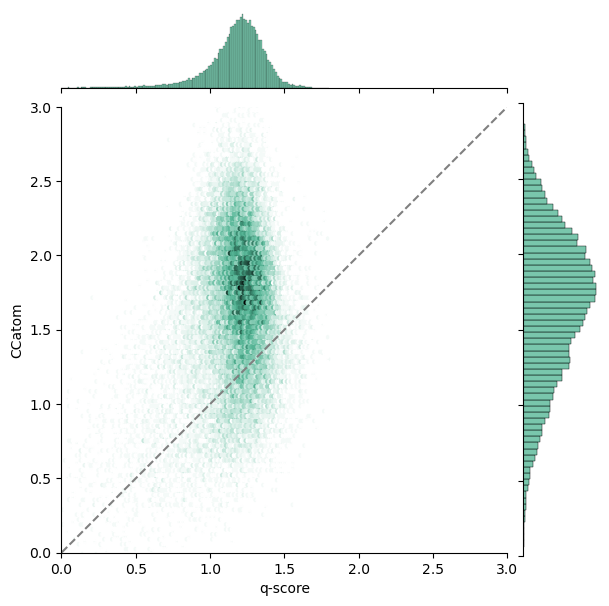

In [96]:
x,y = fisher(my_q), fisher(cc_obs_calc_win3)
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 200})
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
plt.xlim(0,3)
plt.ylim(0,3)
plt.xlabel("q-score")
plt.ylabel("CCatom")

Text(37.597222222222214, 0.5, 'CCatom_me')

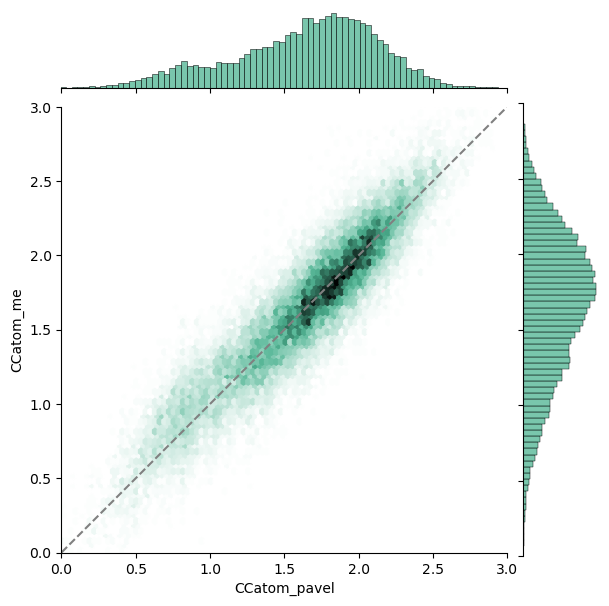

In [92]:
x,y = fisher(cc_atoms_pavel), fisher(cc_obs_calc_win3)
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 100})
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
plt.xlim(0,3)
plt.ylim(0,3)
plt.xlabel("CCatom_pavel")
plt.ylabel("CCatom_me")

(0.0, 5.0)

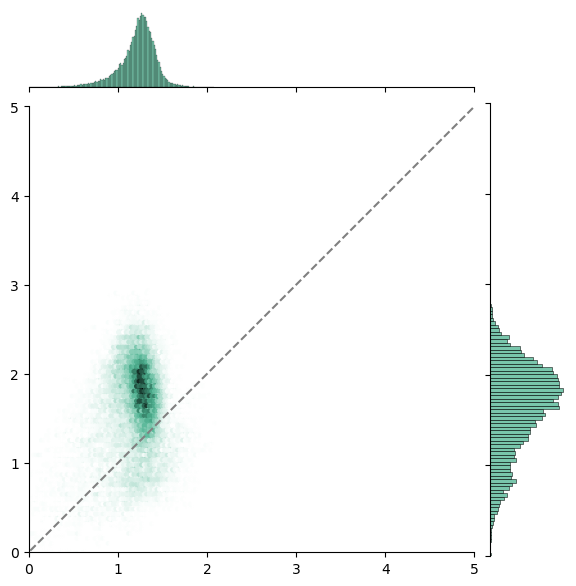

In [69]:
x,y = ref_q, fisher(cc_atoms_pavel)
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 100})
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
plt.xlim(0,5)
plt.ylim(0,5)

In [32]:
print(np.corrcoef(ref_q, my_q))
#print(np.corrcoef(fisher(ref_q), fisher(my_q)))

[[1.         0.92508933]
 [0.92508933 1.        ]]


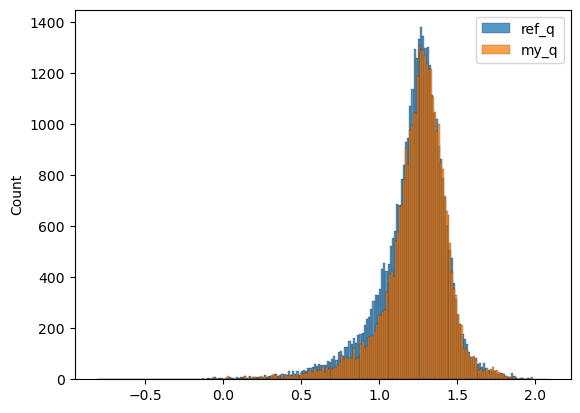

In [34]:
sns.histplot(ref_q,label="ref_q")
sns.histplot(my_q,label="my_q")
plt.legend()

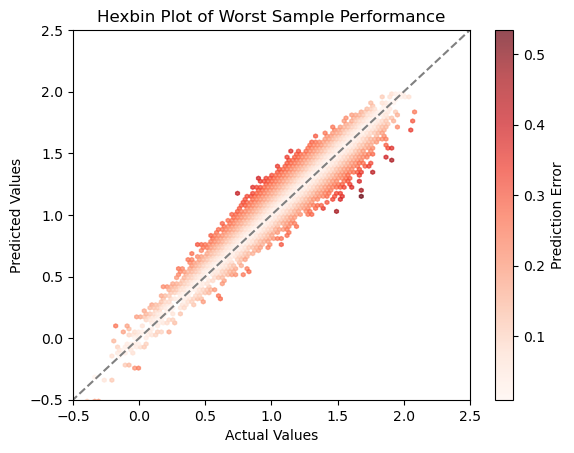

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# see bad samples
y_true = x
y_pred = y

# Calculate prediction errors
errors = np.abs(y_true - y_pred)

# Sort errors and get corresponding indices
sorted_indices = np.argsort(errors)
sorted_errors = errors[sorted_indices]
sorted_true = y_true[sorted_indices]
sorted_pred = y_pred[sorted_indices]

cmap = plt.colormaps["Reds"]
plt.hexbin(sorted_true, sorted_pred, C=sorted_errors, cmap=cmap, gridsize=100, vmin=0.01, alpha=0.7)
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')

# Set colorbar
cbar = plt.colorbar()
cbar.set_label('Prediction Error')

# Set labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Hexbin Plot of Worst Sample Performance')

# Show the plot
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,2.5)
plt.show()


## Start CCmask

In [5]:
import numpy as np
from scipy.ndimage import binary_dilation
from multiprocessing import Pool, shared_memory
from scipy.ndimage import binary_opening, binary_closing, generate_binary_structure
from scipy.ndimage import convolve

def calc_grow_smooth_binary_mask(mask,grow_by=None, smooth_by=None):
    
    # grow
    if grow_by is not None:
        for _ in range(grow_by):
            mask = binary_dilation(mask)

    # smooth
    if smooth_by is not None:
        # Define the kernel as a 3x3x3 cube
        kernel = np.ones((3, 3, 3))
    
        # Perform 3D convolution on the binary mask
        conv = convolve(mask.astype(int), kernel, mode='constant', cval=0)
    
        # Apply the threshold and return the smoothed mask
        mask =  conv >= smooth_by
    return mask

    
    
    
def calc_solvent_mask_morph(atom_mask,radius_voxel,smooth_connectivity=None):

    mask = np.copy(atom_mask)
    
    # Grow the mask by a certain number of voxels
    grow_by = radius_voxel
        

    if smooth_connectivity is not None:
        assert isinstance(smooth_connectivity,int), "Provide integer for smoothing connectivity"
        # Generate a 3D binary structure
        s = generate_binary_structure(3, smooth_connectivity)  # 3 for 3D, 2 for connectivity
        
        # Perform the closing operation
        mask = binary_closing(mask, structure=s)

    solvent_mask = ~mask
    return mask,solvent_mask




In [6]:
# map box indices to original atoms


# dictionary version
# Convert the rows in ijk and atom_indices to tuples
# tuples_ijk = [tuple(row) for row in ijk]
# tuples_atom_indices = [tuple(row) for row in atom_indices]

# # Create a dictionary mapping rows in ijk to their indices
# dict_ijk = {tuple: index for index, tuple in enumerate(tuples_ijk)}

# # Use this dictionary to create a list mapping rows in atom_indices to their corresponding indices in ijk
# index_map = [dict_ijk[tuple] for tuple in tuples_atom_indices]

# # index_map[i] is now the index in ijk of the row that matches atom_indices[i]
# ijk_reordered = ijk[index_map]

# # Now ijk_reordered should match atom_indices
# assert np.all(ijk_reordered == atom_indices)

# pandas version


In [7]:
import mrcfile

def write_mrc(filename,array,voxel_sizes=(1.0,1.0,1.0)):

    density_cartesian = array
    data = np.transpose(density_cartesian, (2, 1, 0))
    
    with mrcfile.new(filename, overwrite=True) as mrc:
        mrc.set_data(data.astype(np.float32))
        mrc.voxel_size = voxel_sizes


In [8]:
import numpy as np

def get_window(index, arr_shape, window_rad, output_format='1d', index_format='1d'):
    # Ensure index is a numpy array
    if not isinstance(index, np.ndarray):
        index = np.array(index)

    # Convert 1D indices to 3D indices
    if index.ndim == 1:
        index = np.array(np.unravel_index(index, arr_shape)).T  # Transpose to get (n, 3) shape

    if index.ndim != 2 or index.shape[1] != 3:  # Check for correct shape
        raise ValueError("The index array should be of shape (n) or (i, j, k)")

    # Create window around the origin
    window = np.array(np.meshgrid(
        np.arange(-window_rad, window_rad+1),
        np.arange(-window_rad, window_rad+1),
        np.arange(-window_rad, window_rad+1),
        indexing='ij'
    )).reshape(3, -1).T

    # Add window to each index and clip to array shape
    window_indices_3d = (index[:, None] + window[None]).reshape(-1, 3)
    window_indices_3d = np.clip(window_indices_3d, 0, np.array(arr_shape) - 1)

    if index_format == '1d':
        # Convert 3D indices to 1D
        window_indices = np.ravel_multi_index(window_indices_3d.T, arr_shape)

        # Reshape the output according to the specified format
        if output_format == '1d':
            window_indices = window_indices.reshape(len(index), -1)
        elif output_format == '3d':
            window_side_len = 2*window_rad + 1
            window_indices = window_indices.reshape((len(index), window_side_len, window_side_len, window_side_len))
        else:
            raise ValueError("Invalid output format. Choose from '1d' or '3d'")
        
        return window_indices
    elif index_format == '3d':
        return window_indices_3d
    else:
        raise ValueError("Invalid index format. Choose from '1d' or '3d'")

# # tests
# n = mask_positions_atom
# ijk = np.array(np.unravel_index(n,grid_size)).T
# out1 = get_window(ijk,np.array([338, 338, 338]),2,output_format="1d")
# out2 = get_window(ijk,np.array([338, 338, 338]),2,output_format="3d")
# out3 = get_window(n,np.array([338, 338, 338]),2,output_format="1d")
# out4 = get_window(n,np.array([338, 338, 338]),2,output_format="3d")
# assert np.all(out1==out3)
# assert np.all(out2==out4)
# assert np.all(out1==out2.reshape(out2.shape[0],np.prod(out2.shape[1:])))

In [9]:

# densities = trilinear_interpolation(arr1,voxel_size,atoms_xyz)

## Windowed cc

In [10]:
# get arrays to compare
d_obs = mmm.map_manager().map_data().as_numpy_array()
mmm.generate_map(d_min=d_min,model=mmm.model(),map_id="calc1")
mmm.generate_map(d_min=d_min+0.1,model=mmm.model(),map_id="calc2")
d_calc1 = mmm.get_map_data_by_id(map_id="calc1").as_numpy_array()
d_calc2 = mmm.get_map_data_by_id(map_id="calc2").as_numpy_array()

d_obs= d_obs.astype(np.float32)
d_calc1= d_calc1.astype(np.float32)
d_calc2= d_calc2.astype(np.float32)


#window_shape = np.array([window_size,window_size,window_size])

In [28]:
%%time



# from mmtbx.maps.correlation import from_map_map_atoms_per_atom
# cc_atoms2 = from_map_map_atoms_per_atom(mmm.map_manager().map_data(),
#                             mmm.get_map_data_by_id(map_id="calc1"),
#                             model.get_sites_cart(),
#                             model.unit_cell_crystal_symmetry().unit_cell(),
#                             1.3)
# cc_atoms_pavel2 = cc_atoms2.as_numpy_array()

CPU times: user 564 ms, sys: 3.04 ms, total: 567 ms
Wall time: 567 ms


In [40]:
def localized_cc(atoms_xyz,arr1,arr2,voxel_size,window_size):

    # check input
    assert arr1.shape == arr2.shape, "Must use volume arrays of same shape"
    grid_size = arr1.shape
    # assign atoms coords to voxels in a simple way
    atom_indices = np.rint(atoms_xyz / voxel_diameter).astype(int)

    # make a mask the same shape as the volume, with only the atom voxels set to True
    atom_mask = np.full(grid_size,False)
    atom_mask[atom_indices[:, 0], atom_indices[:, 1], atom_indices[:, 2]] = True

    # grow and smooth the atom mask. We will interpolate the CC later so it is important to be slightly bigger
    atom_mask_smooth = calc_grow_smooth_binary_mask(atom_mask,grow_by=2,smooth_by=3)
                                                   
    # get atom voxel positions in a flat array. 
    # Note this is actually more voxels than atoms because it is grown and smoothed
    pos_atom_smooth = np.flatnonzero(atom_mask_smooth)
    
    # get a 2d array of (n_positions,n_window_indices) where the second dim is the flat indices of a window around each atom position
    window_inds = get_window(pos_atom_smooth, grid_size, window_size//2, index_format='1d')
    
    # select from the density arrays to get two 2d arrays of density, shape (n_positions,n_window_indices)
    arr1_windows = arr1.flat[window_inds]
    arr2_windows = arr2.flat[window_inds]
    
    
    # calculate the rowwise corrcoefs
    cc_atoms_smooth = rowwise_corrcoef(arr1_windows,arr2_windows)
    
    # get the ijk indices of all atom voxel positions
    ijk = np.array(np.nonzero(atom_mask_smooth)).T
    i,j,k = ijk[:,0],ijk[:,1],ijk[:,2]
    
    # create a new box with cc values at every atom voxel
    cc_box = np.zeros(grid_size)
    cc_box[i,j,k] = cc_atoms_smooth
    
    # trilinearly interpolate from atom cc voxels to atom coordinates to get a more precise localized value
    cc_atoms_tri = trilinear_interpolation(cc_box,voxel_diameter,atoms_xyz)
    
    # For comparison to the nearest (no interpolations)
    atom_indices = np.rint(atoms_xyz / voxel_diameter).astype(int)
    cc_atoms = cc_box[atom_indices[:, 0], atom_indices[:, 1], atom_indices[:, 2]] 
    print(np.corrcoef(cc_atoms,cc_atoms_tri)[0][1])

    return cc_atoms_tri


In [41]:
import numpy as np
from scipy.spatial import cKDTree

import numpy as np
from scipy.spatial import cKDTree

def nearest_voxel(points, grid_shape, neighborhood_size=1):
    # Step 1: Get a rough estimate of the nearest voxels
    rough_estimates = np.rint(points).astype(int)
    
    # Step 2: Define a large neighborhood around all rough estimates
    x_start, y_start, z_start = np.maximum(rough_estimates.min(axis=0) - neighborhood_size, 0)
    x_end, y_end, z_end = np.minimum(rough_estimates.max(axis=0) + neighborhood_size + 1, np.array(grid_shape))
    
    # Step 3: Generate all voxel centers in the large neighborhood
    x = np.arange(x_start, x_end) + 0.5
    y = np.arange(y_start, y_end) + 0.5
    z = np.arange(z_start, z_end) + 0.5
    voxel_centers = np.array(np.meshgrid(x, y, z, indexing='ij')).reshape(3, -1).T
    
    # Step 4: Create a KDTree from the voxel centers in the large neighborhood
    tree = KDTree(voxel_centers)
    
    # Step 5: Query the KDTree for the nearest voxel center for each point
    dists, idxs = tree.query(points)
    
    # Step 6: Convert the indices in the KDTree back to voxel coordinates
    closest_voxels = voxel_centers[idxs] - np.array([0.5, 0.5, 0.5])
    
    return closest_voxels.astype(int)





In [42]:
atoms_xyz = model.get_sites_cart().as_numpy_array()
voxel_diameter = mm.pixel_sizes()[0]
#radius_voxel = int(np.ceil(1.4/voxel_diameter)) # for later when using pixel size rather than 
#window_size = 4

In [43]:
%%time

cc_obs_calc_win3 = localized_cc(atoms_xyz,d_obs,d_calc1,voxel_diameter,3)
cc_calc_calc = localized_cc(atoms_xyz,d_calc1,d_calc2,voxel_diameter,3)

0.969216633644224
0.9731413663574259
CPU times: user 6.61 s, sys: 936 ms, total: 7.54 s
Wall time: 7.54 s


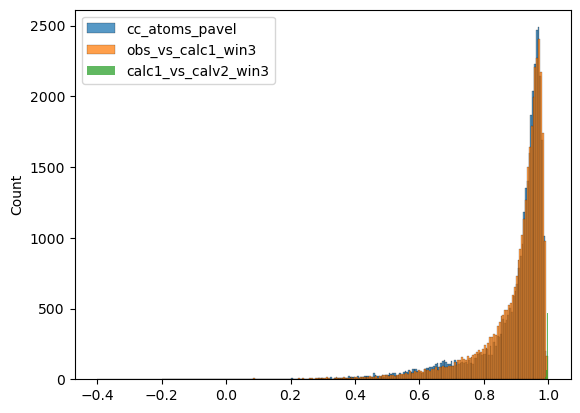

In [44]:
import seaborn as sns
sns.histplot(cc_atoms_pavel,label="cc_atoms_pavel")
sns.histplot(cc_obs_calc_win3,label="obs_vs_calc1_win3")
sns.histplot(cc_calc_calc,label="calc1_vs_calv2_win3")

plt.legend()

(0.0, 3.0)

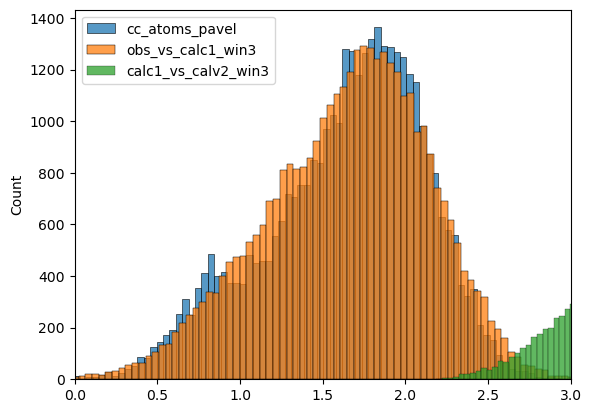

In [45]:
import seaborn as sns
sns.histplot(fisher(cc_atoms_pavel),label="cc_atoms_pavel")
sns.histplot(fisher(cc_obs_calc_win3),label="obs_vs_calc1_win3")
sns.histplot(fisher(cc_calc_calc),label="calc1_vs_calv2_win3")
plt.legend()
plt.xlim(0,3)

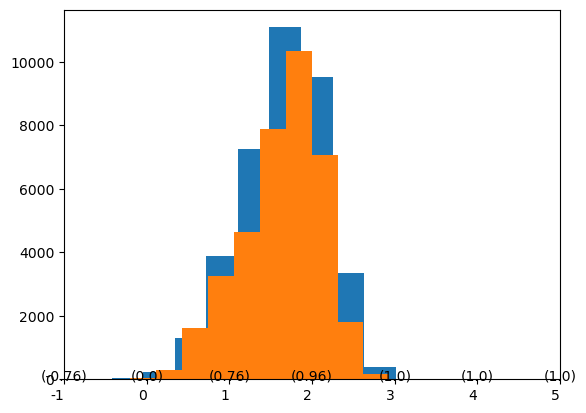

In [47]:
#Fisher transformation and its inverse
def fisher_transform(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher_transform(z):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

# Simulate some data
r_values = cc_obs_calc_win3
z_values = fisher_transform(r_values)

# Choose tick locations in Fisher-transformed space
z_ticks = np.arange(-1,6,step=1)

# Convert tick locations back to correlation coefficients
r_ticks = inverse_fisher_transform(z_ticks)

# Make the histogram
plt.hist(z_values)


# Simulate some data
r_values = cc_atoms_pavel
z_values = fisher_transform(r_values)
plt.hist(z_values)

# # Simulate some data
# r_values = my_q
# z_values = fisher_transform(r_values)
# plt.hist(z_values)

# Set the x-ticks
ax = plt.gca()
ax.set_xticks(z_ticks)
ax.set_xticklabels(np.round(z_ticks, 2), ha='right')

# Add second level of labels for correlation values
for z, r in zip(z_ticks, r_ticks):
    ax.text(z, -30, f'({np.round(r, 2)})', ha='center')

plt.show()

In [112]:
ref_q.shape

(37062,)

In [113]:
cc_calc_calc.shape

(37062,)

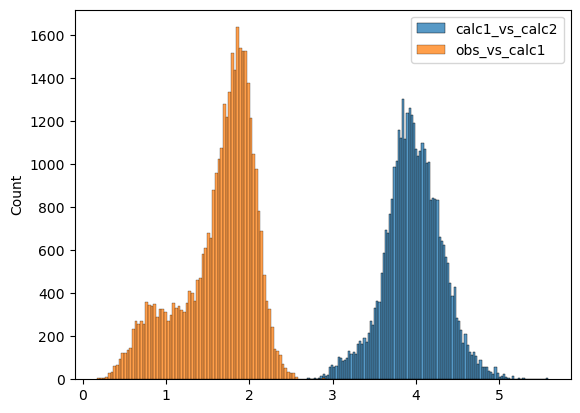

In [27]:
a,b = fisher(cc_calc_calc), fisher(cc_obs_calc)
sns.histplot(a,label="calc1_vs_calc2")
sns.histplot(b,label="obs_vs_calc1")
plt.legend()

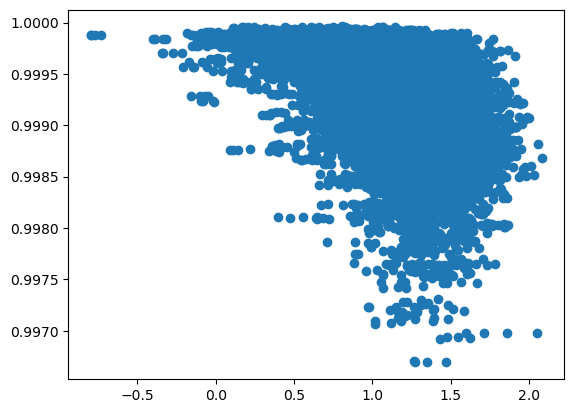

In [51]:
plt.scatter(ref_q,cc_calc_calc)

In [52]:
ref_q

array([0.19846534, 0.98821461, 1.22663328, ..., 1.39837549, 1.75462825,
       1.41049876])

(0.0, 2.0)

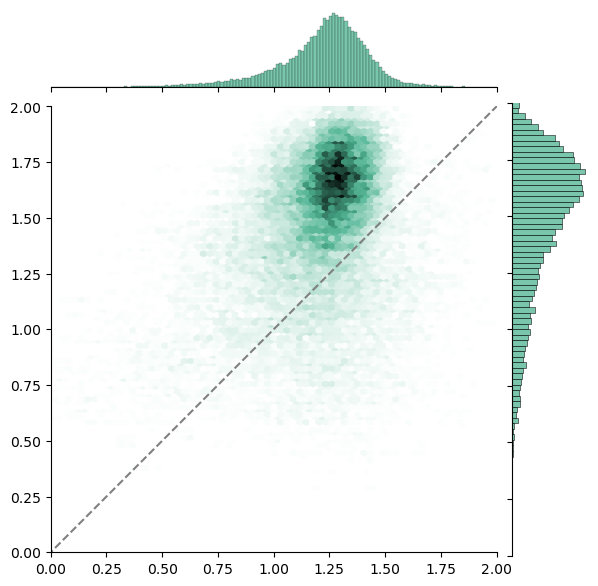

In [54]:
# plot greg q vs cc
x,y = ref_q,fisher(cc_obs_calc)
#sns.kdeplot(x=x, y=y, cmap='Reds', fill=True, thresh=0.05) # slow for large data
fig = sns.jointplot(x=x, y=y, kind="hex", color="#4CB391",joint_kws={'gridsize': 100})
fig.ax_joint.set_aspect('equal')
bump = 200
plt.plot([-bump, bump], [-bump, bump], color='gray', linestyle='--')
plt.xlim(0,2)
plt.ylim(0,2)

In [298]:
# are they really not the same thing?

In [56]:
# qscore_bad_cc_good = (q_me<0.69) & (cc_atoms_tri>0.95)
# selection = flex.bool(qscore_bad_cc_good)
# with open("qscore_bad_cc_good.pdb","w") as fh:
#     print(model.select(selection).model_as_pdb(),file=fh)


In [57]:
dm.process_model_file("6cvm_with_B.pdb")

'6cvm_with_B.pdb'

In [59]:
model_withb = dm.get_model(filename="6cvm_with_B.pdb")
B = model_withb.get_atoms().extract_b().as_numpy_array()

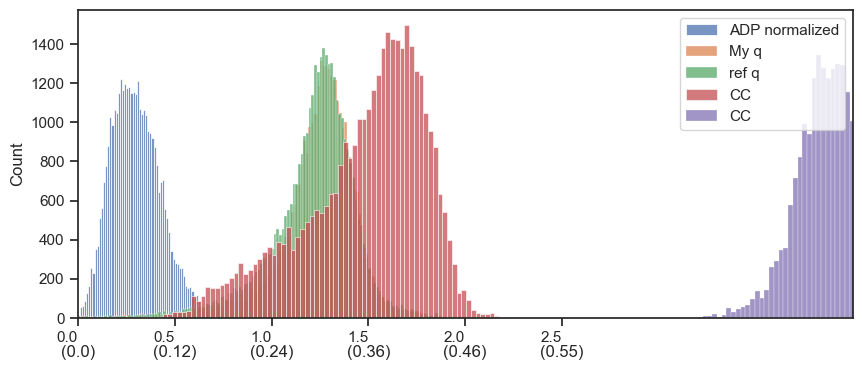

In [146]:
B_norm = min_max_normalize(B)

#Fisher transformation and its inverse
scale = 0.5

def fisher_transform(r):
    return 1/scale * np.log((1 + r) / (1 - r))

def inverse_fisher_transform(z):
    return (np.exp(scale * z) - 1) / (np.exp(scale * z) + 1)

    
plt.figure(figsize=(10, 4)) 
#B_norm = ecdf_match(B_norm,q_me)
sns.histplot(B_norm,label="ADP normalized")
sns.histplot(my_q,label="My q")
sns.histplot(ref_q,label="ref q")
sns.histplot(fisher(cc_obs_calc),label="CC")
sns.histplot(fisher(cc_calc_calc),label="CC")
plt.legend()

# Choose tick locations in Fisher-transformed space
z_ticks = z_ticks = np.arange(0, 3, 0.5) 

# Convert tick locations back to correlation coefficients
r_ticks = inverse_fisher_transform(z_ticks)


# Set the x-ticks
ax = plt.gca()
ax.set_xticks(z_ticks)
ax.set_xticklabels(np.round(z_ticks, 2), ha='right')

# Add second level of labels for correlation values
for z, r in zip(z_ticks, r_ticks):
    ax.text(z, -200, f'({np.round(r, 2)})', ha='center')
plt.xlim(0,4)
plt.show()

In [131]:
cc_obs_calc.mean()

0.8809924736958753

In [71]:
# import pandas as pd

# def idx_map_mask_atom(ijk_mask,ijk_atom):
#     # Convert the arrays to pandas DataFrames
#     df_atom_indices = pd.DataFrame(ijk_atom, columns=['i', 'j', 'k'])
#     df_ijk = pd.DataFrame(ijk_mask, columns=['i', 'j', 'k'])
    
#     # Add a column to df_ijk with the original row index
#     df_ijk['index'] = df_ijk.index
    
#     # Merge the dataframes to match the rows in atom_indices and ijk
#     df_merged = pd.merge(df_atom_indices, df_ijk, on=['i', 'j', 'k'])
    
#     # The 'index' column in df_merged now gives the index in ijk of each row in atom_indices
#     index_map = df_merged['index'].values
    
#     # Now you can reorder ijk to match atom_indices
#     ijk_reordered = ijk[index_map]
    
#     # Now ijk_reordered should match atom_indices
#     assert np.all(ijk_reordered == atom_indices)
#     return index_map

# End new cc

In [67]:
from functools import partial
import multiprocessing as mp
from multiprocessing import Pool, Manager
from multiprocessing.shared_memory import SharedMemory
import random
arr1_shared = mp.Array("f", int(np.prod(arr1.shape)))
arr1_np = np.frombuffer(arr1_shared.get_obj(), dtype=np.float32)
arr1_np[:] = arr1.ravel()


In [19]:
arr_shape = arr1.shape
work = list(mask_positions_atom)
random.shuffle(work)

arr1_shared = mp.Array("f", int(np.prod(arr1.shape)))
arr1_np = np.frombuffer(arr1_shared.get_obj(), dtype=np.float32)
arr1_np[:] = arr1.ravel()


arr2_shared = mp.Array("f", int(np.prod(arr2.shape)))
arr2_np = np.frombuffer(arr2_shared.get_obj(), dtype=np.float32)
arr2_np[:] = arr2.ravel()


mask_shared = mp.Array("b", int(np.prod(mol_mask.shape)))
mask_np = np.frombuffer(mask_shared.get_obj(), dtype=np.int8)
mask_np[:] = mol_mask.ravel().astype(np.int8)

out_shared = mp.Array("f", int(np.prod(out.shape)))
out_np = np.frombuffer(out_shared.get_obj(), dtype=np.float32)
out_np[:] = out.ravel()


In [102]:
# quick run to catch errors
for i in mask_positions_atom[:20]:
    corr_window(i, # the index to center window on
                          arr1_shared=arr1_shared,
                          arr2_shared=arr2_shared,
                          mask_shared=mask_shared,
                          out_shared=out_shared,
                          arr_shape=arr_shape,
                          window_shape=window_shape)

In [21]:
%%time
def worker_fn(queue,
              arr1_shared,
              arr2_shared,
              mask_shared,
              out_shared,
              arr_shape,
              window_shape):
    while True:
        i = queue.get()
        if i == 'STOP':
            queue.task_done()
            break
        try:
            # Inside the worker function, create a new numpy array view to the shared array
            
            # Here you can modify arr1, and the changes will be visible to all processes
            corr_window(i, # the index to center window on
                      arr1_shared=arr1_shared,
                      arr2_shared=arr2_shared,
                      mask_shared=mask_shared,
                      out_shared=out_shared,
                      arr_shape=arr_shape,
                      window_shape=window_shape)
        except Exception as e:
            print(f"An error occurred in worker function: {e}")
            raise
        finally:
            queue.task_done()

# Create a queue to hold the tasks
queue = mp.JoinableQueue()

# Now you can manually create each subprocess
processes = []
nproc = 10
for _ in range(nproc):
    p = mp.Process(target=worker_fn, args=(queue,
                                              arr1_shared,
                                              arr2_shared,
                                              mask_shared,
                                              out_shared,
                                              arr_shape,
                                              window_shape))
    p.start()
    processes.append(p)

# Now you can add tasks to the queue
for i in work:
    queue.put(i)

# Add a 'STOP' message for each worker
for _ in range(nproc):
    queue.put('STOP')

# Wait for all tasks in the queue to be processed
queue.join()

# Wait for all processes to finish
for p in processes:
    p.join()

CPU times: user 2.61 s, sys: 604 ms, total: 3.21 s
Wall time: 36.4 s


In [22]:
out = out_np.reshape(arr_shape)

In [23]:
import mrcfile
data = out
density_cartesian = out
data = np.transpose(density_cartesian, (2, 1, 0))

with mrcfile.new('DEBUG_corr_map.mrc', overwrite=True) as mrc:
    mrc.set_data(data.astype(np.float32))
    mrc.voxel_size = mmm.map_manager().pixel_sizes()

In [44]:
# timings
# Just atom pixels in 6cvm (35s with 10 cores)

In [84]:
ijk = np.array(atom_mask.nonzero()).T

In [85]:
ijk

array([[ 27, 151, 160],
       [ 27, 153, 160],
       [ 27, 185, 178],
       ...,
       [311, 153, 178],
       [311, 185, 160],
       [311, 187, 160]])

In [89]:
len(ijk*voxel_diameter)

37062

In [90]:
len(atoms_xyz)

37062

In [80]:
atoms_xyz.min()

17.157

In [26]:
cc_atom = out[atom_mask]

<Axes: ylabel='Count'>

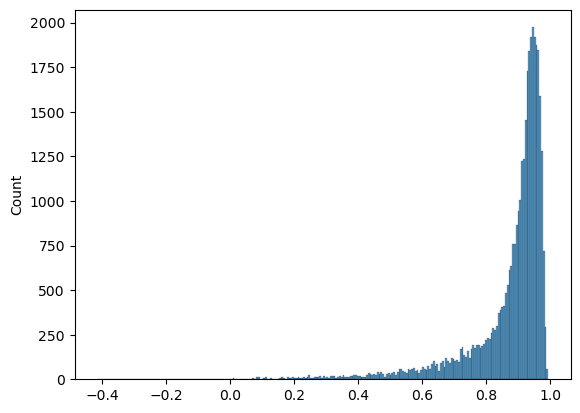

In [28]:
import seaborn as sns
sns.histplot(cc_atom)